<a href="https://colab.research.google.com/github/ksjeyabarani/W266_Project/blob/master/W266_Project_Report_Generation_And_Charts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, we will generate reports and charts to analyze. Note that the previous evaluation steps generates various metrics like ROUGE, BLEU, Repeation scores but did not produce the Coverage and Density metrics. We will first generate them here.

In the below step, we generate an auxiliary metrics file containing coverage, density and normalized density metrics

In [ ]:
# mount drive to store models and retrieve data
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/My Drive/W266_Project/pegasus/


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/
/content/drive/My Drive/W266_Project/pegasus


In [ ]:
!pip3 install pprint
!pip3 install pandas

  Created wheel for pprint: filename=pprint-0.1-cp36-none-any.whl size=1251 sha256=54ad17b4d89b4f9d7c5d9431d8762cee1248552ee3aee8a3b2087795fdd67d7c
  Stored in directory: /root/.cache/pip/wheels/42/d4/c6/16a6495aecc1bda5d5857bd036efd50617789ba9bea4a05124
Successfully built pprint


In [ ]:
import sys
import pprint

sys.path.append('/content/drive/My Drive/W266_Project/pegasus')

from pegasus.eval.extractive.extractive_scorer import ExtractiveScorer
import numpy as np
import os

def calculateCDN(source_text_list, target_text_list, predicted_text_list):
  e = ExtractiveScorer(["coverage", "density", "normalized_density"])
  pred_cov = []
  pred_density = []
  pred_norm_density = []
  for i in range(len(source_text_list)):
    r = e.score(target_text_list[i], predicted_text_list[i],
                source_text_list[i])
    pred_cov.append(r['coverage'].prediction)
    pred_density.append(r['density'].prediction)
    pred_norm_density.append(r['normalized_density'].prediction)
  res = dict()
  res['coverage'] = [np.min(pred_cov), np.mean(pred_cov), np.max(pred_cov)]
  res['density'] = [np.min(pred_density), np.mean(pred_density), 
                    np.max(pred_density)]
  res['normalized_density'] = [np.min(pred_norm_density), 
                               np.mean(pred_norm_density), 
                               np.max(pred_norm_density)]
  return res

def parse_file(file_path, extra_skip):
  with open(file_path, "r") as f:
    doc_begin = False
    doc_number = -1
    doc_contents = []
    buf = []
    for line in f:
      line = line.rstrip()
      if line.startswith('-----:'):
        doc_begin = True
        if doc_number >= 0:
          doc_contents.append(' '.join(buf))
        doc_number = doc_number + 1
        buf = []
      elif extra_skip and doc_begin:
        doc_begin = False
      else:
        doc_begin = False
        buf.append(line)
    doc_contents.append(' '.join(buf))
    return doc_contents

def process_dir(dir_path):
  files = os.listdir(dir_path)
  file_dict = dict([(k.split("-", 1)[0], "{0}/{1}".format(dir_path, k)) for k in files])
  source_text_list = parse_file(file_dict['inputs'], extra_skip=True)
  target_text_list = parse_file(file_dict['targets'], extra_skip=False)
  pred_text_list = parse_file(file_dict['predictions'], extra_skip=False)
  metrics = calculateCDN(source_text_list, target_text_list, pred_text_list)
  pprint.pprint(metrics)
  with open("{0}/cdn.csv".format(dir_path), "w") as f:
    for k in sorted(metrics.keys()):
      f.write("{0},{1}\n".format(k, ','.join([str(x) for x in metrics[k]])))

def add_cdn(dir_path):
  for d in os.listdir(dir_path):
    if not d.startswith("."):
      try:
        print("Processing dir " + d)
        sub_dir = "{0}/{1}".format(dir_path, d)
        process_dir(sub_dir)
      except:
        print("Error when creating cdn for {}".format(d))
        
add_cdn('/content/drive/My Drive/W266_Project/pegasus/metrics_and_logs')


In the next step, we will generate an excel report comparing coverage and density metrics across our evaluation runs to analyze and deduce.

In [ ]:

import sys
import pprint

sys.path.append('/content/drive/My Drive/W266_Project/pegasus')

from pegasus.eval.extractive.extractive_scorer import ExtractiveScorer
import numpy as np
import os
import pandas as pd

def read_cov_norm(dir_path):
  try:
    file_name = "{0}/cdn.csv".format(dir_path)
    df = pd.read_csv(file_name, names=["scorer", "min", "avg", "max"])
    return "{0} | {1}".format(df['avg'][0], df['avg'][2])
  except:
    return "N/A"

def parse_exp_name(d):
  (prefix, bs, ba) = d.rsplit("_", 2)
  bsba = "{0}_{1}".format(bs, ba)
  model = None
  testset = None
  if "_" in prefix:
    (model, testset) = prefix.split("_", 1)
    if model.startswith("multi") or model.startswith("reddit"):
      model = "{0}_{1}".format(model, testset.split("_", 1)[0])
      if "_" in testset:
        testset = testset.split("_", 1)[1]
      else:
        testset = model
    #if testset.endswith("multi_news") or testset.endswith("reddit_tifu"):
      #if testset != "multi_news" or testset != "reddit_tifu":
        #testset = testset.split("_", 1)[1]
  else:
    model = prefix
    if model == "base":
      testset = "cnn"
    else:
      testset = model
  return (model, testset, bsba)

def generate_cn_dict(dir_path):
  groups = dict()
  skips = ['arxiv', 'xsum', 'wrong', 'big_patent']
  for d in sorted(os.listdir(dir_path)):
    if not d.startswith(".") and not any([x in d for x in skips]):
      try:
        print("Processing dir " + d)
        sub_dir = "{0}/{1}".format(dir_path, d)
        (model, testset, bsba) = parse_exp_name(d)
        if model not in groups:
          groups[model] = dict()
        if testset not in groups[model]:
          groups[model][testset] = dict()
        groups[model][testset][bsba] = read_cov_norm(sub_dir)
      except:
        raise
  return groups;

def create_cn_report(dir_path):
  groups = generate_cn_dict(dir_path)
  models = ['base', 'cnn', 'multi_news', 'billsum', 'pubmed', 'reddit_tifu', 'aeslc']
  testsets = ['cnn', 'multi_news', 'billsum', 'pubmed', 'reddit_tifu', 'aeslc']
  bsba = ["bs1_ba5", "bs5_ba5", "bs10_ba5", "bs10_ba1", "bs10_ba9"]
  labels = ["beamsearch_1_α_0.5(coverage|density)",
            "beamsearch_5_α_0.5(coverage|density)",
            "beamsearch_10_α_0.5(coverage|density)",
            "beamsearch_10_α_0.1(coverage|density)",
            "beamsearch_10_α_0.9(coverage|density)"]
  with open("{0}/coverage_and_normalized_density_comparison.csv".format(dir_path), "w") as f:
    f.write("Model,Testset,{0}\n".format(",".join(labels)))
    for model in models:
      for testset in testsets:
        line = []
        print("Model {0}, TestSet : {1}".format(model, testset))
        for b in bsba:
          line.append(groups[model][testset][b])
        f.write("{0},{1},{2}\n".format(model, testset, ",".join(line)))
      
create_cn_report('/content/drive/My Drive/W266_Project/pegasus/metrics_and_logs')



We will then create separate excel sheets to generate individual report for each evaluation metrics

In [ ]:

import sys
import pprint

sys.path.append('/content/drive/My Drive/W266_Project/pegasus')

from pegasus.eval.extractive.extractive_scorer import ExtractiveScorer
import numpy as np
import os
import pandas as pd

def compute_text_metrics(path):
  try:
    stats = dict()
    # Read Rogue Scores
    compute_rouge_rep_len_scores(path, stats, 0, 12)
    # Read Bleu Score
    compute_bleu_score(path, stats)
    # Read rep_len_scores
    compute_rouge_rep_len_scores(path, stats, 13, 14)
    new_stats = dict()
    for k in stats.keys():
      if k.startswith("rouge"):
        new_stats[k] = "{0} | {1} | {2}".format(round(stats[k]['P'], 4),
                                                round(stats[k]['R'], 4),
                                                round(stats[k]['F'], 4))
      elif k == 'bleu':
        new_stats[k] = str(round(stats[k],4))
      elif k.startswith("regs"):
        new_stats[k] = "{0} | {1}".format(round(stats[k]['T'], 4), round(stats[k]['P'],4))
      else:
        new_stats[k] = "{0} | {1} | {2}".format(round(stats[k]['T'], 4),
                                                round(stats[k]['P'], 4),
                                                round(stats[k]['R'], 4))
    return new_stats
  except:
    raise
    return dict()

def compute_rouge_rep_len_scores(path, stats, skiprows, nrows):
  df = pd.read_csv(path, skiprows=skiprows, nrows=nrows, names=["scorer", "min", "avg", "max"])
  for i in range(len(df)):
    scorer = df['scorer'][i]
    avg = df['avg'][i]
    if scorer.endswith("-token"):
      scorer = scorer.rsplit("-", 1)[0]
    (alg,prf) = scorer.rsplit("-", 1)
    #print("{0}\t{1}\t{2}\t{3}\t{4}".format(alg, prf, min,avg, max))
    if alg not in stats:
      stats[alg] = dict()
    stats[alg][prf] = avg

def compute_bleu_score(path, stats):
  # Read bleu score
  df = pd.read_csv(path, skiprows=12, nrows=1, names=["scorer", "min", "avg", "max"])
  alg = df['scorer'][0]
  avg = df['avg'][0]
  if alg not in stats:
    stats[alg] = avg


def parse_exp_name(d):
  (prefix, bs, ba) = d.rsplit("_", 2)
  bsba = "{0}_{1}".format(bs, ba)
  model = None
  testset = None
  if "_" in prefix:
    (model, testset) = prefix.split("_", 1)
    if model.startswith("multi") or model.startswith("reddit"):
      model = "{0}_{1}".format(model, testset.split("_", 1)[0])
      if "_" in testset:
        testset = testset.split("_", 1)[1]
      else:
        testset = model
    #if testset.endswith("multi_news") or testset.endswith("reddit_tifu"):
      #if testset != "multi_news" or testset != "reddit_tifu":
        #testset = testset.split("_", 1)[1]
  else:
    model = prefix
    if model == "base":
      testset = "cnn"
    else:
      testset = model
  return (model, testset, bsba)

def get_text_metrics_file(dir_path):
  files = os.listdir(dir_path)
  file_dict = dict([(k.split("-", 1)[0], "{0}/{1}".format(dir_path, k)) for k in files])
  return file_dict['text_metrics']

def generate_metrics_dict(dir_path):
  groups = dict()
  skips = ['arxiv', 'xsum', 'wrong', 'big_patent', "metrics", ".csv", ".gsheet"]
  for d in sorted(os.listdir(dir_path)):
    sub_dir = "{0}/{1}".format(dir_path, d)
    if os.path.isdir(sub_dir) and not d.startswith(".") and not any([x in d for x in skips]):
      try:
        print("Processing dir " + d)
        text_metrics_file = get_text_metrics_file(sub_dir)
        (model, testset, bsba) = parse_exp_name(d)
        res = compute_text_metrics(text_metrics_file)
        print("Result : {0}".format(res))
        for key in res.keys():
          if key not in groups:
            groups[key] = dict()
          if model not in groups[key]:
            groups[key][model] = dict()
          if testset not in groups[key][model]:
            groups[key][model][testset] = dict()
          groups[key][model][testset][bsba] = res[key]
      except KeyError:
        pass
  return groups;

def create_metrics_report(dir_path):
  groups = generate_metrics_dict(dir_path)
  models = ['base', 'cnn', 'multi_news', 'billsum', 'pubmed', 'reddit_tifu', 'aeslc']
  testsets = ['cnn', 'multi_news', 'billsum', 'pubmed', 'reddit_tifu', 'aeslc']
  bsba = ["bs1_ba5", "bs5_ba5", "bs10_ba5", "bs10_ba1", "bs10_ba9"]
  rouge_labels = ["beamsearch_1_α_0.5(precision|recall|f1)",
                  "beamsearch_5_α_0.5(precision|recall|f1)",
                  "beamsearch_10_α_0.5(precision|recall|f1)",
                  "beamsearch_10_α_0.1(precision|recall|f1)",
                  "beamsearch_10_α_0.9(precision|recall|f1)"]
  bleu_labels = ["beamsearch_1_α_0.5",
                  "beamsearch_5_α_0.5",
                  "beamsearch_10_α_0.5",
                  "beamsearch_10_α_0.1",
                  "beamsearch_10_α_0.9"]
  regs_labels = ["beamsearch_1_α_0.5(target|predicted)",
                  "beamsearch_5_α_0.5(target|predicted)",
                  "beamsearch_10_α_0.5(target|predicted)",
                  "beamsearch_10_α_0.1(target|predicted)",
                  "beamsearch_10_α_0.9(target|predicted)"]
  length_labels = ["beamsearch_1_α_0.5(target|predicted|relative)",
                  "beamsearch_5_α_0.5(target|predicted|relative)",
                  "beamsearch_10_α_0.5(target|predicted|relative)",
                  "beamsearch_10_α_0.1(target|predicted|relative)",
                  "beamsearch_10_α_0.9(target|predicted|relative)"]
  for scorer in groups.keys():
    labels = length_labels
    if scorer.startswith("rouge"):
      labels = rouge_labels
    elif scorer == 'bleu':
      labels = bleu_labels
    elif scorer.startswith("regs"):
      labels = regs_labels

    with open("{0}/metrics_{1}.csv".format(dir_path, scorer), "w") as f:
      f.write("Model,Testset,{0}\n".format(",".join(labels)))
      for model in models:
        for testset in testsets:
          line = []
          print("Model {0}, TestSet : {1}".format(model, testset))
          for b in bsba:
            try:
              line.append(groups[scorer][model][testset][b])
            except KeyError:
              line.append("N/A")
          f.write("{0},{1},{2}\n".format(model, testset, ",".join(line)))
      
create_metrics_report('/content/drive/My Drive/W266_Project/pegasus/metrics_and_logs')



We will look at visualizing the results by comparing evaluations of different models.

In [ ]:
%cd /content/drive/My Drive/W266_Project/pegasus/metrics_and_logs

import pandas

def collectStats(file_name, dirs):
  stats = dict()
  for d in dirs:
    path = "./{0}/{1}".format(d, file_name)
    # Read Rouge Scores
    compute_rouge_rep_len_scores(path, stats, 0, 12)
    # Read Bleu Score
    compute_bleu_score(path, stats)
    # Read rep_len_scores
    compute_rouge_rep_len_scores(path, stats, 13, 14)
  return stats

def compute_rouge_rep_len_scores(path, stats, skiprows, nrows):
  df = pandas.read_csv(path, skiprows=skiprows, nrows=nrows, names=["scorer", "min", "avg", "max"])
  for i in range(len(df)):
    scorer = df['scorer'][i]
    min = df['min'][i]
    max = df['max'][i]
    avg = df['avg'][i]
    if scorer.endswith("-token"):
      scorer = scorer.rsplit("-", 1)[0]
    (alg,prf) = scorer.rsplit("-", 1)
    #print("{0}\t{1}\t{2}\t{3}\t{4}".format(alg, prf, min,avg, max))
    if alg not in stats:
      stats[alg] = dict()
    if prf not in stats[alg]:
      stats[alg][prf] = dict()
    if 'min' not in stats[alg][prf]:
      stats[alg][prf]['min'] = []
    if 'max' not in stats[alg][prf]:
      stats[alg][prf]['max'] = []
    if 'avg' not in stats[alg][prf]:
      stats[alg][prf]['avg'] = []
    stats[alg][prf]['min'].append(min)
    stats[alg][prf]['max'].append(max)
    stats[alg][prf]['avg'].append(avg)

def compute_bleu_score(path, stats):
  # Read bleu score
  df = pandas.read_csv(path, skiprows=12, nrows=1, names=["scorer", "min", "avg", "max"])
  alg = df['scorer'][0]
  min = df['min'][0]
  max = df['max'][0]
  avg = df['avg'][0]
  if alg not in stats:
    stats[alg] = dict()
  if 'min' not in stats[alg]:
    stats[alg]['min'] = []
  if 'max' not in stats[alg]:
    stats[alg]['max'] = []
  if 'avg' not in stats[alg]:
    stats[alg]['avg'] = []
  stats[alg]['min'].append(min)
  stats[alg]['max'].append(max)
  stats[alg]['avg'].append(avg)




/content/drive/My Drive/W266_Project/pegasus/metrics_and_logs


In [ ]:
# Base Model evaluating CNN_dailynews dataset
base_cnn_file_name = "text_metrics-1500000-.test.txt"
base_cnn_dirs = ['base_bs10_ba1', 'base_bs10_ba5', 'base_bs10_ba9', 'base_bs1_ba5', 'base_bs5_ba5']
base_cnn_stats = collectStats(base_cnn_file_name, base_cnn_dirs)
print(base_cnn_stats)

import pprint
pprint.pprint(base_cnn_stats)


{'rouge1': {'R': {'min': [0.39568400000000004, 0.408533, 0.413804, 0.39516399999999996, 0.399584], 'max': [0.457172, 0.466603, 0.47106400000000004, 0.45764799999999994, 0.46043500000000004], 'avg': [0.424407, 0.437755, 0.441941, 0.42692299999999994, 0.42933999999999994]}, 'P': {'min': [0.293595, 0.282616, 0.27526799999999996, 0.265422, 0.281587], 'max': [0.3497, 0.33402600000000005, 0.32545599999999997, 0.318952, 0.331875], 'avg': [0.320767, 0.306305, 0.298617, 0.29203, 0.306442]}, 'F': {'min': [0.32243299999999997, 0.321873, 0.321885, 0.306215, 0.319966], 'max': [0.36493200000000003, 0.362122, 0.360099, 0.349661, 0.35935900000000004], 'avg': [0.34334000000000003, 0.341648, 0.34124099999999996, 0.327338, 0.340198]}}, 'rouge2': {'R': {'min': [0.14432999999999999, 0.148964, 0.147325, 0.138157, 0.14239100000000002], 'max': [0.19877999999999998, 0.204727, 0.20238399999999998, 0.18953, 0.196772], 'avg': [0.17016199999999998, 0.174574, 0.175003, 0.16309400000000002, 0.167874]}, 'P': {'min': 

In [ ]:
# CNN dailyNews Model evaluating CNN_dailynews dataset
cnn_cnn_file_name = "text_metrics-210000-.test.txt"
cnn_cnn_dirs = ['cnn_bs10_ba1', 'cnn_bs10_ba5', 'cnn_bs10_ba9', 'cnn_bs1_ba5', 'cnn_bs5_ba5']
cnn_cnn_stats = collectStats(cnn_cnn_file_name, cnn_cnn_dirs)
print(cnn_cnn_stats)

{'rouge1': {'R': {'min': [0.291188, 0.357682, 0.44846400000000003, 0.45647, 0.358098], 'max': [0.352161, 0.410631, 0.5069170000000001, 0.508238, 0.417804], 'avg': [0.321275, 0.383108, 0.478525, 0.48203500000000005, 0.387266]}, 'P': {'min': [0.486483, 0.420596, 0.38715900000000003, 0.402309, 0.449359], 'max': [0.5551229999999999, 0.48616899999999996, 0.448629, 0.45486499999999996, 0.510363], 'avg': [0.521742, 0.45223100000000005, 0.419138, 0.42792600000000003, 0.479386]}, 'F': {'min': [0.351378, 0.379277, 0.405121, 0.41988500000000006, 0.388913], 'max': [0.40977600000000003, 0.43177600000000005, 0.456958, 0.464657, 0.44396800000000003], 'avg': [0.380081, 0.403348, 0.430442, 0.44237299999999996, 0.41577700000000006]}}, 'rouge2': {'R': {'min': [0.135442, 0.149981, 0.188472, 0.193377, 0.15733], 'max': [0.182836, 0.201321, 0.248315, 0.242108, 0.207571], 'avg': [0.157134, 0.173678, 0.21646700000000002, 0.21666300000000002, 0.180911]}, 'P': {'min': [0.224448, 0.177476, 0.164642, 0.169239, 0.1

In [ ]:
# Base Model evaluating aeslc dataset
base_aeslc_file_name = "text_metrics-1500000-.test.txt"
base_aeslc_dirs = ['base_aeslc_bs10_ba1', 'base_aeslc_bs10_ba5', 'base_aeslc_bs10_ba9', 'base_aeslc_bs1_ba5', 'base_aeslc_bs5_ba5']
base_aeslc_stats = collectStats(base_aeslc_file_name, base_aeslc_dirs)
print(base_aeslc_stats)

{'rouge1': {'R': {'min': [0.139295, 0.149538, 0.147753, 0.211416, 0.162476], 'max': [0.26287699999999997, 0.268714, 0.26551199999999997, 0.33824299999999996, 0.2864], 'avg': [0.19817, 0.20780900000000002, 0.20725100000000002, 0.270848, 0.22044899999999998]}, 'P': {'min': [0.036884, 0.038734, 0.038982, 0.047636000000000005, 0.040839], 'max': [0.072825, 0.074931, 0.074602, 0.08240399999999999, 0.076652], 'avg': [0.053183, 0.055915999999999993, 0.055547000000000006, 0.063172, 0.057293]}, 'F': {'min': [0.055686, 0.057482000000000005, 0.058753, 0.073353, 0.061698], 'max': [0.105549, 0.107971, 0.10818699999999999, 0.123089, 0.11377999999999999], 'avg': [0.078559, 0.082444, 0.082163, 0.09586900000000001, 0.08580299999999999]}}, 'rouge2': {'R': {'min': [0.032255, 0.039819, 0.037247, 0.05754, 0.039667], 'max': [0.115699, 0.123376, 0.12898099999999998, 0.15317, 0.126167], 'avg': [0.067643, 0.076964, 0.076512, 0.10403599999999999, 0.078226]}, 'P': {'min': [0.006987999999999999, 0.008428, 0.008048

In [ ]:
# aeslc Model evaluating aeslc dataset
aeslc_aeslc_file_name = "text_metrics-32000-.test.txt"
aeslc_aeslc_dirs = ['aeslc_bs10_ba1', 'aeslc_bs10_ba5', 'aeslc_bs10_ba9', 'aeslc_bs1_ba5', 'aeslc_bs5_ba5']
aeslc_aeslc_stats = collectStats(aeslc_aeslc_file_name, aeslc_aeslc_dirs)
print(aeslc_aeslc_stats)

{'rouge1': {'R': {'min': [0.325815, 0.346458, 0.34929, 0.326768, 0.350973], 'max': [0.46808999999999995, 0.483274, 0.49991499999999994, 0.46636700000000003, 0.498931], 'avg': [0.390629, 0.41435200000000005, 0.421332, 0.396978, 0.424422]}, 'P': {'min': [0.39924699999999996, 0.394861, 0.391536, 0.370832, 0.412368], 'max': [0.556264, 0.546959, 0.551438, 0.528544, 0.56391], 'avg': [0.472421, 0.473843, 0.46998199999999996, 0.447321, 0.49164300000000005]}, 'F': {'min': [0.337588, 0.348377, 0.345956, 0.325077, 0.349695], 'max': [0.46633100000000005, 0.4753, 0.485961, 0.45869, 0.493079], 'avg': [0.395721, 0.41168699999999997, 0.41380200000000006, 0.39100300000000004, 0.42161899999999997]}}, 'rouge2': {'R': {'min': [0.161826, 0.17816300000000002, 0.18158, 0.16406800000000002, 0.18193199999999998], 'max': [0.302349, 0.319265, 0.327178, 0.29179299999999997, 0.320527], 'avg': [0.226845, 0.245619, 0.250292, 0.224185, 0.24660100000000001]}, 'P': {'min': [0.203469, 0.212907, 0.214784, 0.1965660000000

In [ ]:
# cnn Model evaluating aeslc dataset
cnn_aeslc_file_name = "text_metrics-210000-.test.txt"
cnn_aeslc_dirs = ['cnn_aeslc_bs10_ba1', 'cnn_aeslc_bs10_ba5', 'cnn_aeslc_bs10_ba9', 'cnn_aeslc_bs1_ba5', 'cnn_aeslc_bs5_ba5']
cnn_aeslc_stats = collectStats(cnn_aeslc_file_name, cnn_aeslc_dirs)
print(cnn_aeslc_stats)

{'rouge1': {'R': {'min': [0.194705, 0.227338, 0.290369, 0.375382, 0.260994], 'max': [0.329388, 0.358723, 0.418897, 0.513157, 0.394633], 'avg': [0.260754, 0.293995, 0.354119, 0.44536099999999995, 0.325067]}, 'P': {'min': [0.062238999999999996, 0.05856, 0.06561900000000001, 0.068384, 0.068482], 'max': [0.11394100000000001, 0.09568600000000001, 0.103798, 0.098735, 0.10809500000000001], 'avg': [0.085885, 0.076132, 0.083505, 0.08266799999999999, 0.08779400000000001]}, 'F': {'min': [0.089085, 0.089263, 0.102655, 0.11199200000000001, 0.103795], 'max': [0.15496300000000002, 0.142861, 0.157202, 0.158635, 0.160005], 'avg': [0.120504, 0.115052, 0.1279, 0.134647, 0.131748]}}, 'rouge2': {'R': {'min': [0.060923000000000005, 0.053783000000000004, 0.076749, 0.121807, 0.069518], 'max': [0.164019, 0.147517, 0.170771, 0.24142800000000003, 0.171123], 'avg': [0.105583, 0.098095, 0.120429, 0.17826199999999998, 0.116798]}, 'P': {'min': [0.014804, 0.011793000000000001, 0.014969, 0.018989, 0.014452000000000001

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import numpy as np

ROOT_PATH = "/content/drive/My Drive/W266_Project/pegasus/plots/"

def my_plot(subplot, vals1, vals2, xlabel1, xlabel2, ylabel, title, ylim):
  x_pos = np.arange(len(vals1)) 
  width = 0.3   

  subplot.bar(x_pos, vals1, width=0.3, alpha = 0.5, label=xlabel1)
  subplot.bar(x_pos + width, vals2, width=0.3, label=xlabel2)
  subplot.set_ylim(0, ylim) 
  subplot.set_ylabel(ylabel, fontsize=5)
  subplot.set_title(title, fontsize=10)
  subplot.set_xticks(x_pos)
  #subplot.set_title(title)
  #plt.show() 

def draw_plots(title, stats1, model1, stats2, model2, pngfile, ylim=0.6):
  fig, axis = plt.subplots(4, 3, figsize=(50,100))
  fig.suptitle(title, fontsize=50)
  my_plot(axis[0][0], stats1["rouge1"]["R"]['avg'],
          stats2["rouge1"]["R"]['avg'], model1, model2, 
          "rouge1_recall", "ROUGE1 Recall - {0}".format(title), ylim)
  
  my_plot(axis[0][1], stats1["rouge1"]["P"]['avg'],
          stats2["rouge1"]["P"]['avg'], model1, model2,
          "rouge1_precision", "ROUGE1 Precision - {0}".format(title), ylim)

  my_plot(axis[0][2], stats1["rouge1"]["F"]['avg'], 
          stats2["rouge1"]["F"]['avg'], model1, model2,
          "rouge1_f1", "ROUGE1 F1 - {0}".format(title), ylim)
  
  my_plot(axis[1][0], stats1["rouge2"]["R"]['avg'],
          stats2["rouge2"]["R"]['avg'], model1, model2,
          "rouge2_recall", "ROUGE2 Recall - {0}".format(title), ylim)
  
  my_plot(axis[1][1], stats1["rouge2"]["P"]['avg'],
          stats2["rouge2"]["P"]['avg'], model1, model2,
          "rouge2_precision", "ROUGE2 Precision - {0}".format(title), ylim)
  
  my_plot(axis[1][2], stats1["rouge2"]["F"]['avg'],
          stats2["rouge2"]["F"]['avg'], model1, model2,
          "rouge2_f1", "ROUGE2 F1 - {0}".format(title), ylim)
  
  my_plot(axis[2][0], stats1["rougeL"]["R"]['avg'],
          stats2["rougeL"]["R"]['avg'], model1, model2,
          "rougeL_recall", "ROUGEL Recall - {0}".format(title), ylim)
  
  my_plot(axis[2][1], stats1["rougeL"]["P"]['avg'],
          stats2["rougeL"]["P"]['avg'], model1, model2,
          "rougeL_precision", "ROUGEL Precision - {0}".format(title), ylim)
  
  my_plot(axis[2][2], stats1["rougeL"]["F"]['avg'],
          stats2["rougeL"]["F"]['avg'], model1, model2,
          "rougeL_f1", "ROUGEL F1 - {0}".format(title), ylim)
  
  my_plot(axis[3][0], stats1["rougeLsum"]["R"]['avg'],
          stats2["rougeLsum"]["R"]['avg'], model1, model2,
          "rougeLsum_recall", "ROUGELSUM Recall - {0}".format(title), ylim)
  
  my_plot(axis[3][1], stats1["rougeLsum"]["P"]['avg'],
          stats2["rougeLsum"]["P"]['avg'], model1, model2,
          "rougeLsum_precision", "ROUGELSUM Precision - {0}".format(title), ylim)
  
  my_plot(axis[3][2], stats1["rougeLsum"]["F"]['avg'],
          stats2["rougeLsum"]["F"]['avg'], model1, model2,
          "rougeLsum_f1", "ROUGELSUM F1 - {0}".format(title), ylim)
  fpath = "{0}/{1}".format(ROOT_PATH, pngfile)
  fig.show()
  #fig.savefig(fpath)   # save the figure to file
  #plt.close(fig)





Bar Pairs in each subplot represent each experiment varying beam size and beam alpha



                       Experiments
0  Beam Size 10 and beam alpha 0.1
1  Beam Size 10 and beam alpha 0.5
2  Beam Size 10 and beam alpha 0.9
3   Beam Size 1 and beam alpha 0.5
4   Beam Size 1 and beam alpha 0.5







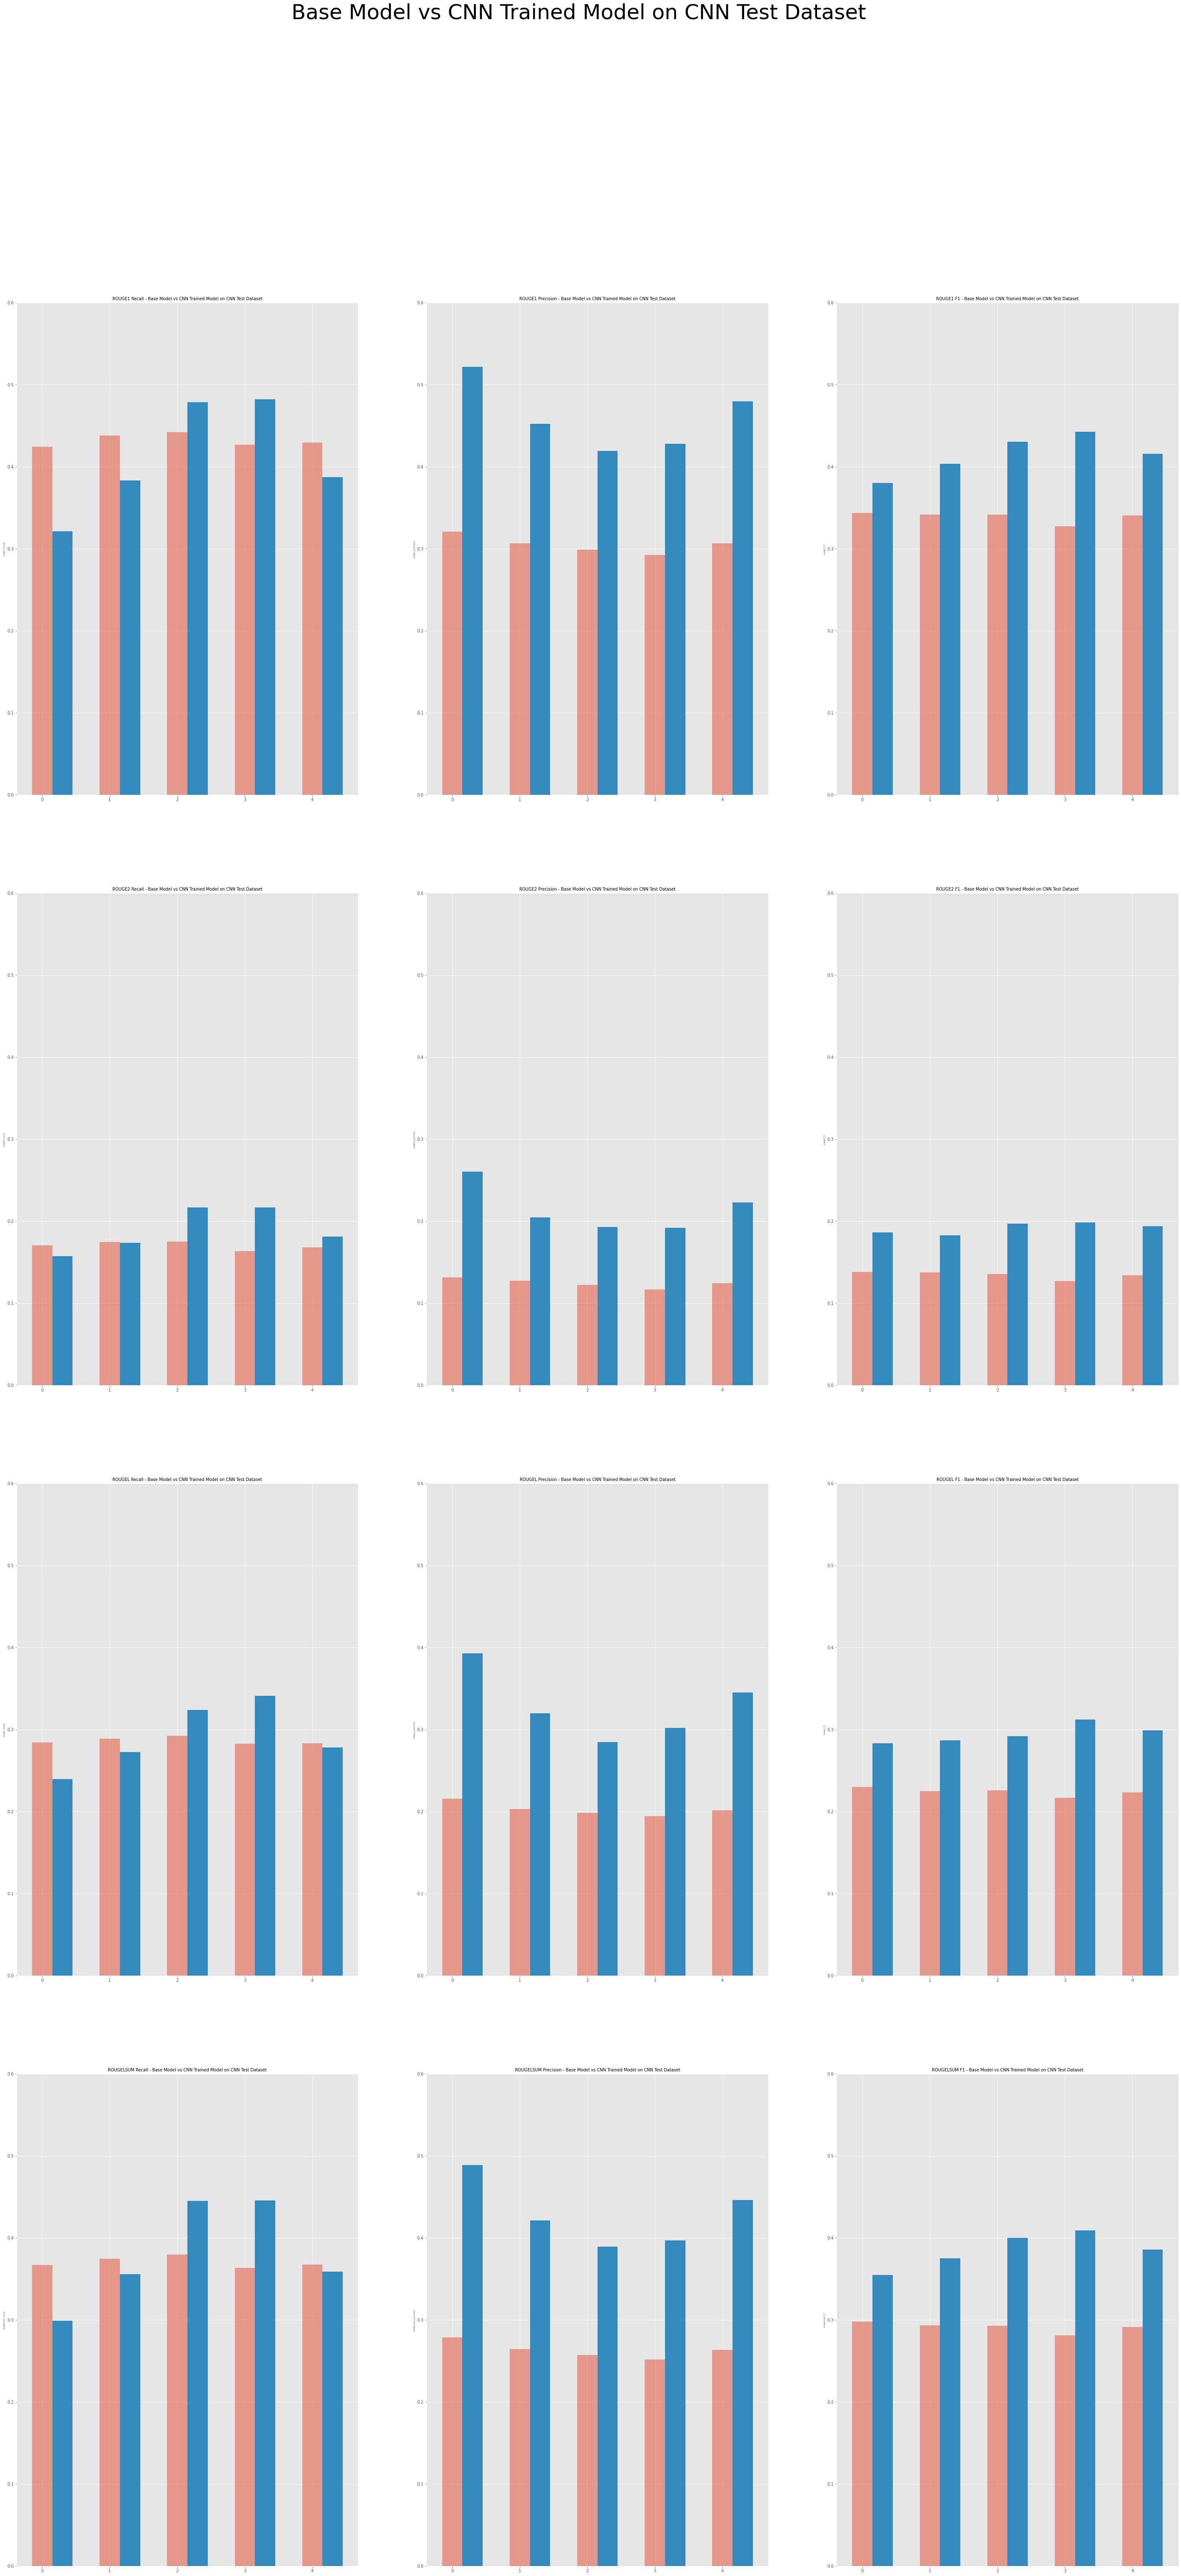

In [ ]:

import pandas as pd
print("\n\nBar Pairs in each subplot represent each experiment varying beam size and beam alpha\n\n\n" )
exp = ['Beam Size 10 and beam alpha 0.1', 'Beam Size 10 and beam alpha 0.5', 
       'Beam Size 10 and beam alpha 0.9', 'Beam Size 1 and beam alpha 0.5', 
       'Beam Size 1 and beam alpha 0.5'] 
print(pd.DataFrame(exp, columns =['Experiments']))    
print("\n\n\n\n")

draw_plots('Base Model vs CNN Trained Model on CNN Test Dataset', 
           base_cnn_stats, "Base_Model", cnn_cnn_stats, "CNN_Model", "base_vs_cnn_on_cnn.png")




Bar Pairs in each subplot represent each experiment varying beam size and beam alpha



                       Experiments
0  Beam Size 10 and beam alpha 0.1
1  Beam Size 10 and beam alpha 0.5
2  Beam Size 10 and beam alpha 0.9
3   Beam Size 1 and beam alpha 0.5
4   Beam Size 1 and beam alpha 0.5







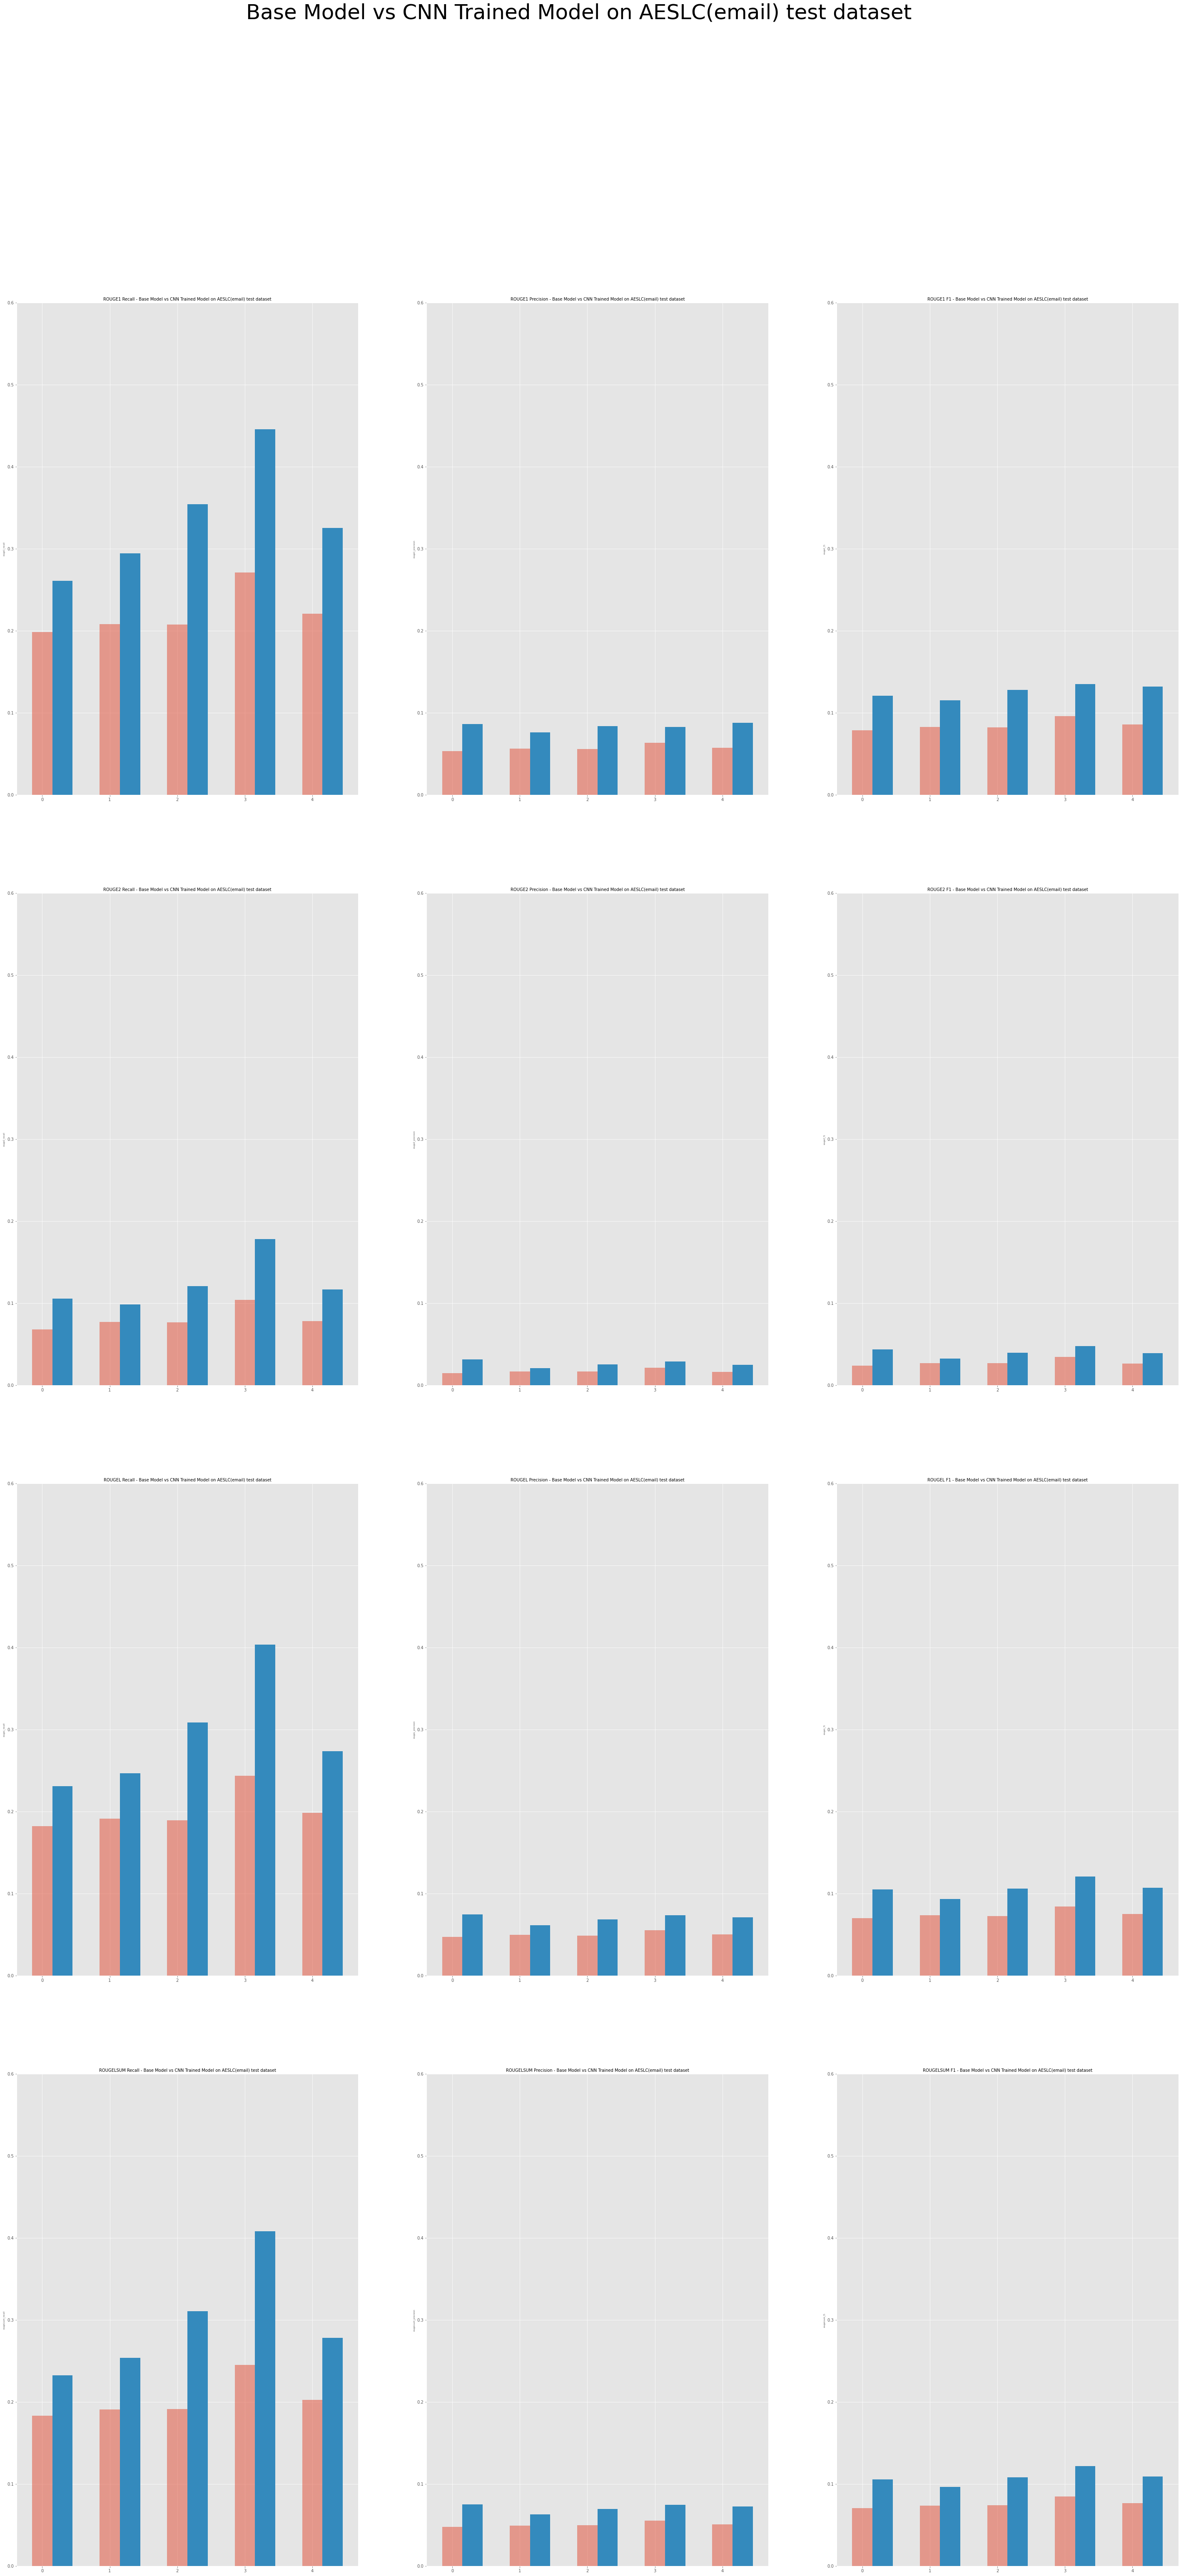

In [ ]:

import pandas as pd
print("\n\nBar Pairs in each subplot represent each experiment varying beam size and beam alpha\n\n\n" )
exp = ['Beam Size 10 and beam alpha 0.1', 'Beam Size 10 and beam alpha 0.5', 
       'Beam Size 10 and beam alpha 0.9', 'Beam Size 1 and beam alpha 0.5', 
       'Beam Size 1 and beam alpha 0.5'] 
print(pd.DataFrame(exp, columns =['Experiments']))    
print("\n\n\n\n")

draw_plots('Base Model vs CNN Trained Model on AESLC(email) test dataset',
           base_aeslc_stats, "Base_Model", cnn_aeslc_stats,
           "CNN_Model", "base_vs_cnn_on_aeslc.png")

{'rouge1': {'R': {'min': [0.150371, 0.194432, 0.230267, 0.23141599999999998, 0.208207], 'max': [0.196347, 0.24493800000000002, 0.278918, 0.277136, 0.25542], 'avg': [0.17219, 0.218935, 0.25438099999999997, 0.254882, 0.23054499999999997]}, 'P': {'min': [0.403484, 0.292605, 0.212376, 0.186792, 0.273556], 'max': [0.48114300000000004, 0.36624, 0.27068600000000004, 0.23960700000000001, 0.35440900000000003], 'avg': [0.44276000000000004, 0.330098, 0.24027199999999999, 0.21235500000000002, 0.314652]}, 'F': {'min': [0.200232, 0.201647, 0.200249, 0.189054, 0.204546], 'max': [0.246121, 0.24303200000000003, 0.241666, 0.232026, 0.24612199999999998], 'avg': [0.221898, 0.22184099999999998, 0.22094699999999998, 0.21057199999999998, 0.225282]}}, 'rouge2': {'R': {'min': [0.047727, 0.051346, 0.058275, 0.049602, 0.051167000000000004], 'max': [0.074379, 0.07914199999999999, 0.085487, 0.069373, 0.07750900000000001], 'avg': [0.060004999999999996, 0.064928, 0.070772, 0.059739999999999994, 0.063372]}, 'P': {'mi

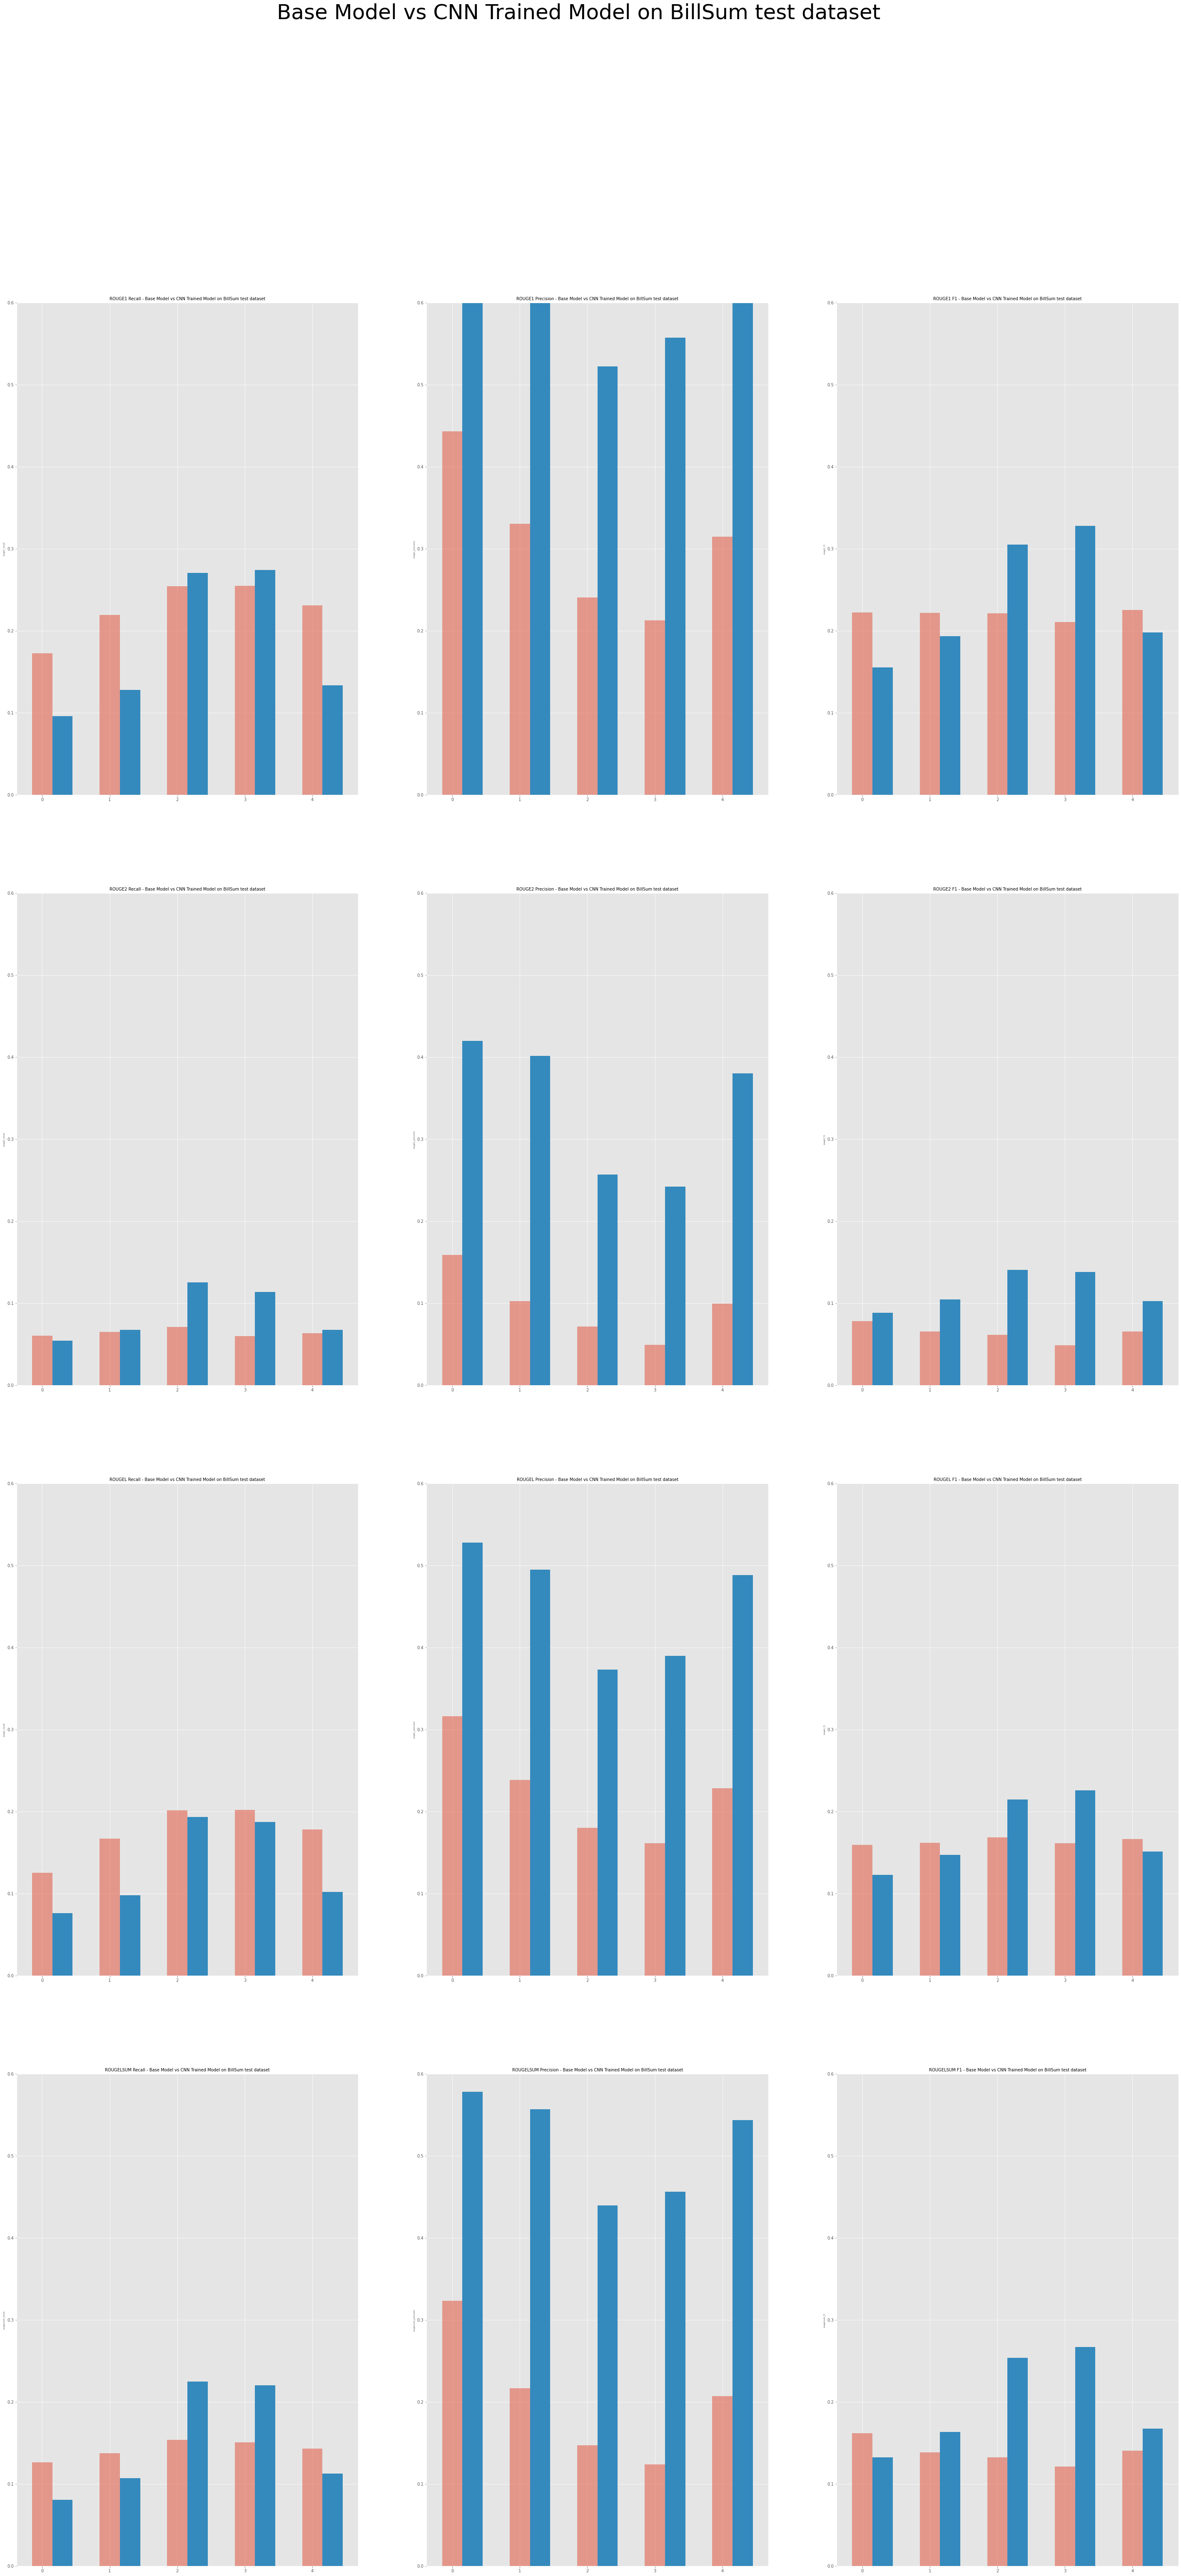

In [ ]:
import pandas as pd

# cnn Model evaluating billsum dataset

base_billsum_file_name = "text_metrics-1500000-.test.txt"
base_billsum_dirs = ['base_billsum_bs10_ba1', 'base_billsum_bs10_ba5', 'base_billsum_bs10_ba9', 'base_billsum_bs1_ba5', 'base_billsum_bs5_ba5']
base_billsum_stats = collectStats(base_billsum_file_name, base_billsum_dirs)
print(base_billsum_stats)

# cnn Model evaluating billsum dataset
cnn_billsum_file_name = "text_metrics-210000-.test.txt"
cnn_billsum_dirs = ['cnn_billsum_bs10_ba1', 'cnn_billsum_bs10_ba5', 'cnn_billsum_bs10_ba9', 'cnn_billsum_bs1_ba5', 'cnn_billsum_bs5_ba5']
cnn_billsum_stats = collectStats(cnn_billsum_file_name, cnn_billsum_dirs)
print(cnn_billsum_stats)

print("\n\nBar Pairs in each subplot represent each experiment varying beam size and beam alpha\n\n\n" )
exp = ['Beam Size 10 and beam alpha 0.1', 'Beam Size 10 and beam alpha 0.5', 
       'Beam Size 10 and beam alpha 0.9', 'Beam Size 1 and beam alpha 0.5', 
       'Beam Size 1 and beam alpha 0.5'] 
print(pd.DataFrame(exp, columns =['Experiments']))    
print("\n\n\n\n")


draw_plots('Base Model vs CNN Trained Model on BillSum test dataset',
           base_billsum_stats, "Base_Model", cnn_billsum_stats,
           "CNN_Model", "base_vs_cnn_on_billsum.png")


{'rouge1': {'R': {'min': [0.182314, 0.208377, 0.225778, 0.163098, 0.214916], 'max': [0.223543, 0.24626199999999998, 0.268549, 0.210867, 0.25203400000000004], 'avg': [0.201793, 0.227239, 0.24710900000000002, 0.188101, 0.233302]}, 'P': {'min': [0.48921499999999996, 0.430249, 0.39369299999999996, 0.23865, 0.439241], 'max': [0.5481739999999999, 0.498395, 0.466054, 0.324896, 0.507792], 'avg': [0.5161060000000001, 0.465337, 0.42855, 0.283057, 0.47321599999999997]}, 'F': {'min': [0.250287, 0.269673, 0.273818, 0.182644, 0.273868], 'max': [0.293527, 0.312158, 0.319809, 0.237197, 0.31650900000000004], 'avg': [0.27176999999999996, 0.2909, 0.29798800000000003, 0.21069200000000002, 0.295238]}}, 'rouge2': {'R': {'min': [0.051386, 0.057422, 0.060902, 0.038288, 0.058065], 'max': [0.077076, 0.085787, 0.087614, 0.059417, 0.08642999999999999], 'avg': [0.063774, 0.070935, 0.073241, 0.048175, 0.071532]}, 'P': {'min': [0.137433, 0.12500899999999998, 0.1111, 0.062868, 0.122751], 'max': [0.194224, 0.174463, 0

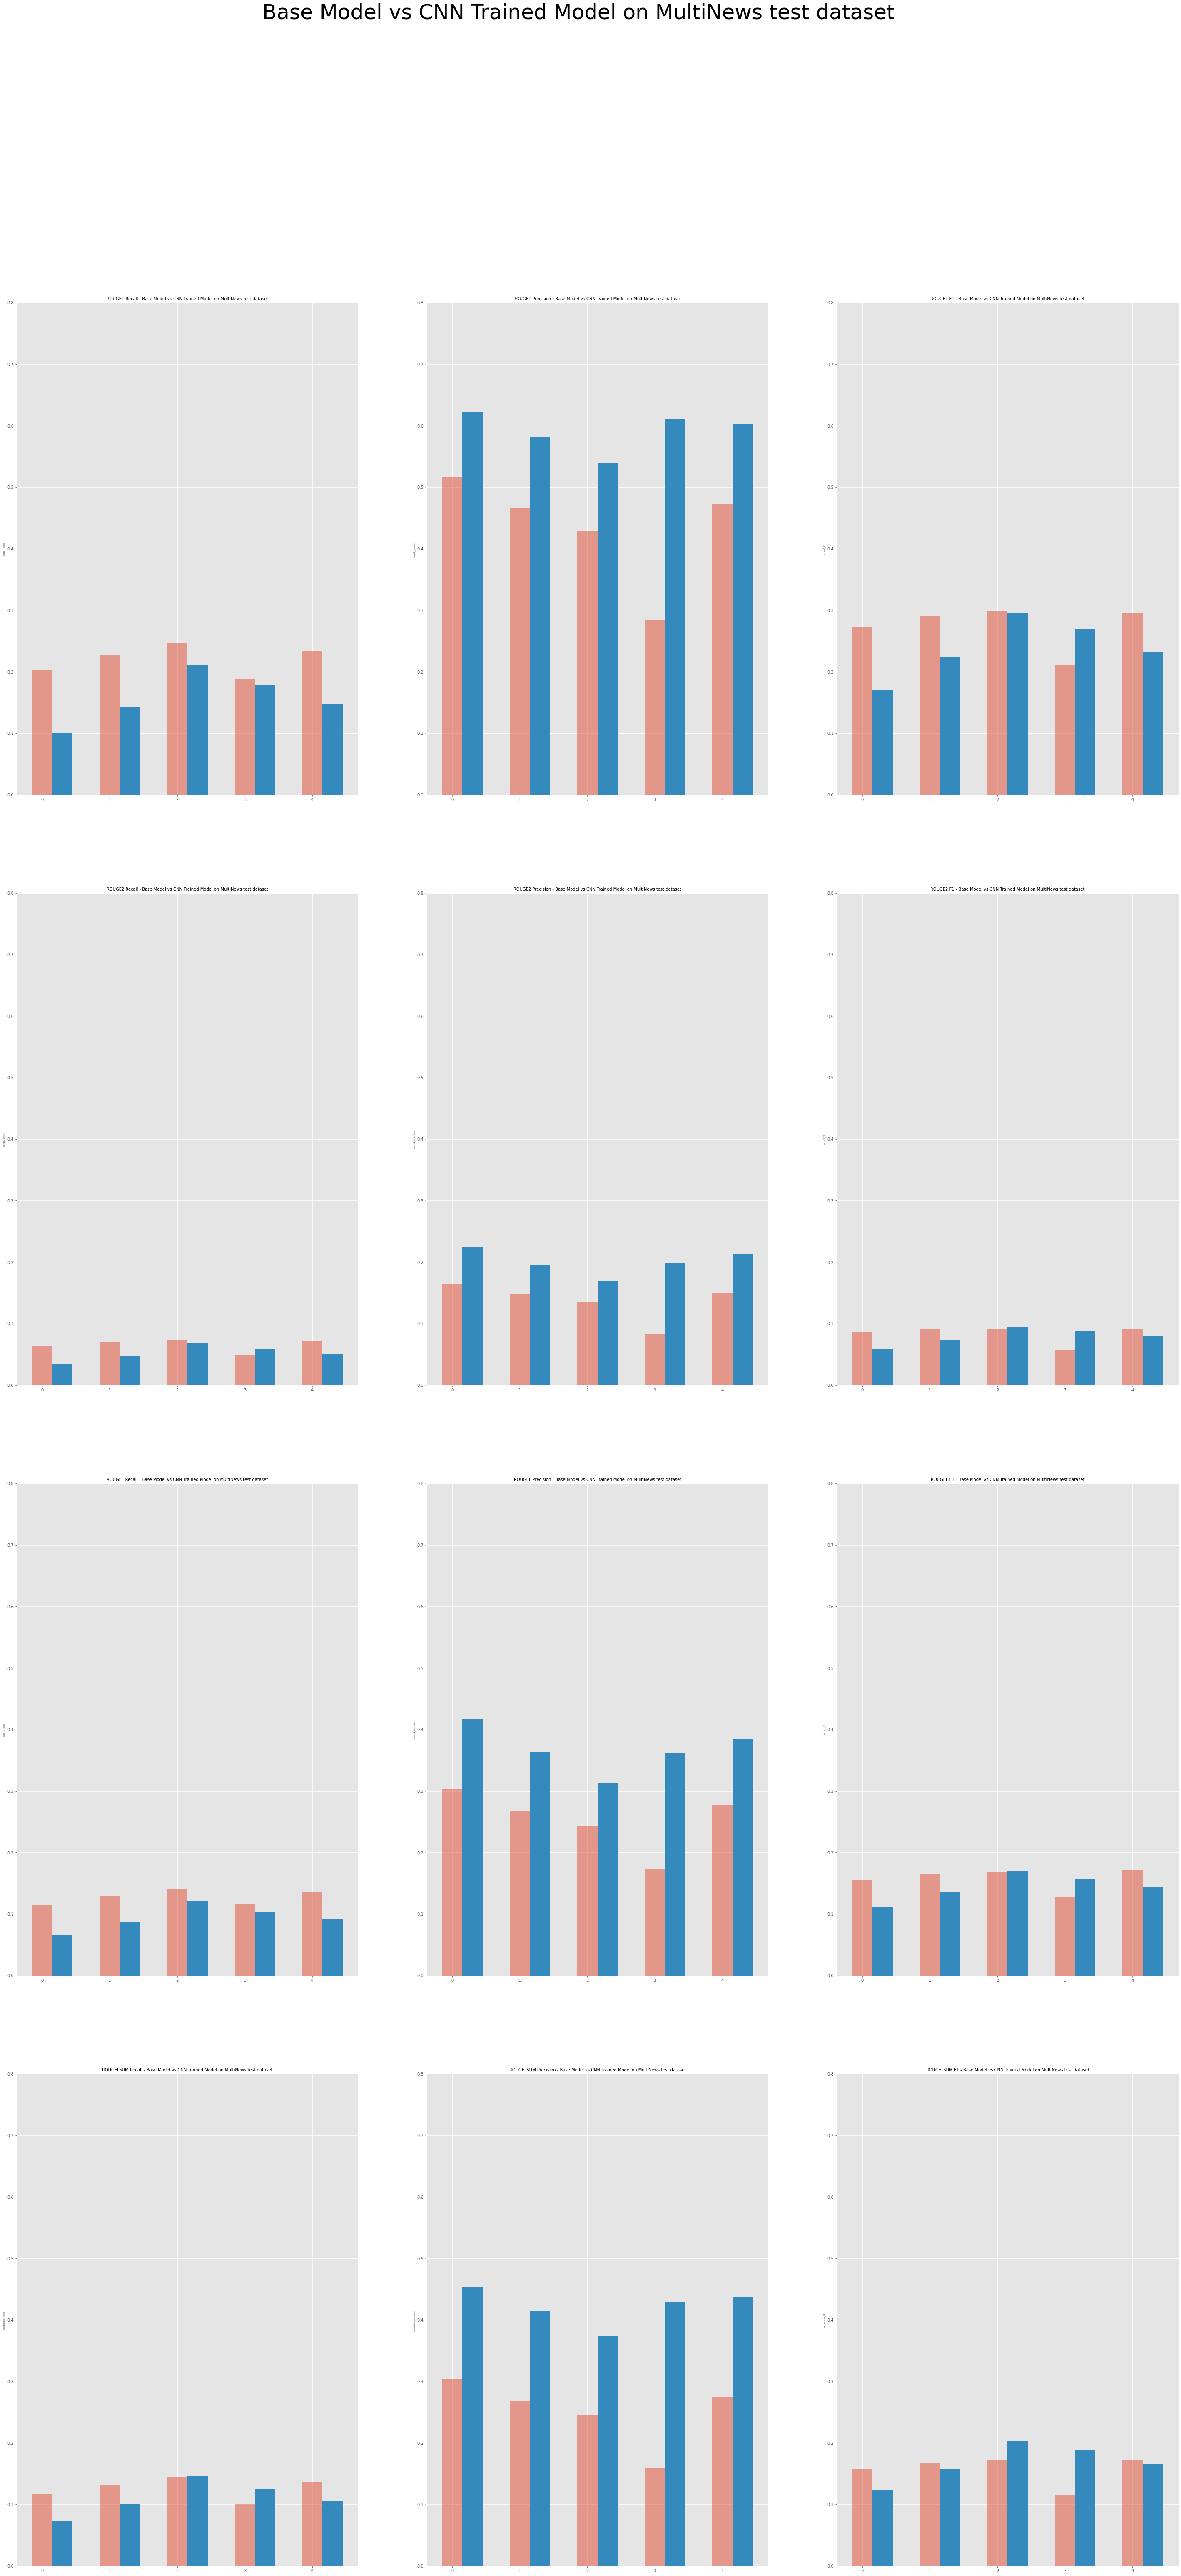

In [ ]:
import pandas as pd

# cnn Model evaluating multi_news dataset

base_multi_news_file_name = "text_metrics-1500000-.test.txt"
base_multi_news_dirs = ['base_multi_news_bs10_ba1', 'base_multi_news_bs10_ba5', 'base_multi_news_bs10_ba9', 'base_multi_news_bs1_ba5', 'base_multi_news_bs5_ba5']
base_multi_news_stats = collectStats(base_multi_news_file_name, base_multi_news_dirs)
print(base_multi_news_stats)

# cnn Model evaluating multi_news dataset
cnn_multi_news_file_name = "text_metrics-210000-.test.txt"
cnn_multi_news_dirs = ['cnn_multi_news_bs10_ba1', 'cnn_multi_news_bs10_ba5', 'cnn_multi_news_bs10_ba9', 'cnn_multi_news_bs1_ba5', 'cnn_multi_news_bs5_ba5']
cnn_multi_news_stats = collectStats(cnn_multi_news_file_name, cnn_multi_news_dirs)
print(cnn_multi_news_stats)

print("\n\nBar Pairs in each subplot represent each experiment varying beam size and beam alpha\n\n\n" )
exp = ['Beam Size 10 and beam alpha 0.1', 'Beam Size 10 and beam alpha 0.5', 
       'Beam Size 10 and beam alpha 0.9', 'Beam Size 1 and beam alpha 0.5', 
       'Beam Size 1 and beam alpha 0.5'] 
print(pd.DataFrame(exp, columns =['Experiments']))    
print("\n\n\n\n")


draw_plots('Base Model vs CNN Trained Model on MultiNews test dataset',
           base_multi_news_stats, "Base_Model", cnn_multi_news_stats,
           "CNN_Model", "base_vs_cnn_on_multi_news.png", ylim=0.8)


{'rouge1': {'R': {'min': [0.30850500000000003, 0.321691, 0.32618800000000003, 0.321317, 0.315535], 'max': [0.374316, 0.388652, 0.394625, 0.390104, 0.384908], 'avg': [0.342308, 0.35512, 0.362016, 0.354214, 0.352254]}, 'P': {'min': [0.107396, 0.104289, 0.103372, 0.10217000000000001, 0.103904], 'max': [0.138977, 0.138261, 0.133218, 0.135018, 0.135179], 'avg': [0.12263399999999999, 0.121178, 0.118519, 0.117574, 0.119433]}, 'F': {'min': [0.15168900000000002, 0.15021500000000002, 0.149927, 0.14693699999999998, 0.149411], 'max': [0.191131, 0.192146, 0.186792, 0.18672, 0.18782000000000001], 'avg': [0.17033099999999998, 0.170958, 0.16894, 0.165726, 0.168495]}}, 'rouge2': {'R': {'min': [0.050347, 0.054572, 0.054285, 0.057135000000000005, 0.054527], 'max': [0.09093, 0.09377, 0.093092, 0.097997, 0.095028], 'avg': [0.068655, 0.072403, 0.07291399999999999, 0.07521, 0.073486]}, 'P': {'min': [0.017755, 0.018365, 0.018108000000000003, 0.017855000000000003, 0.017935], 'max': [0.033808, 0.033688, 0.03294

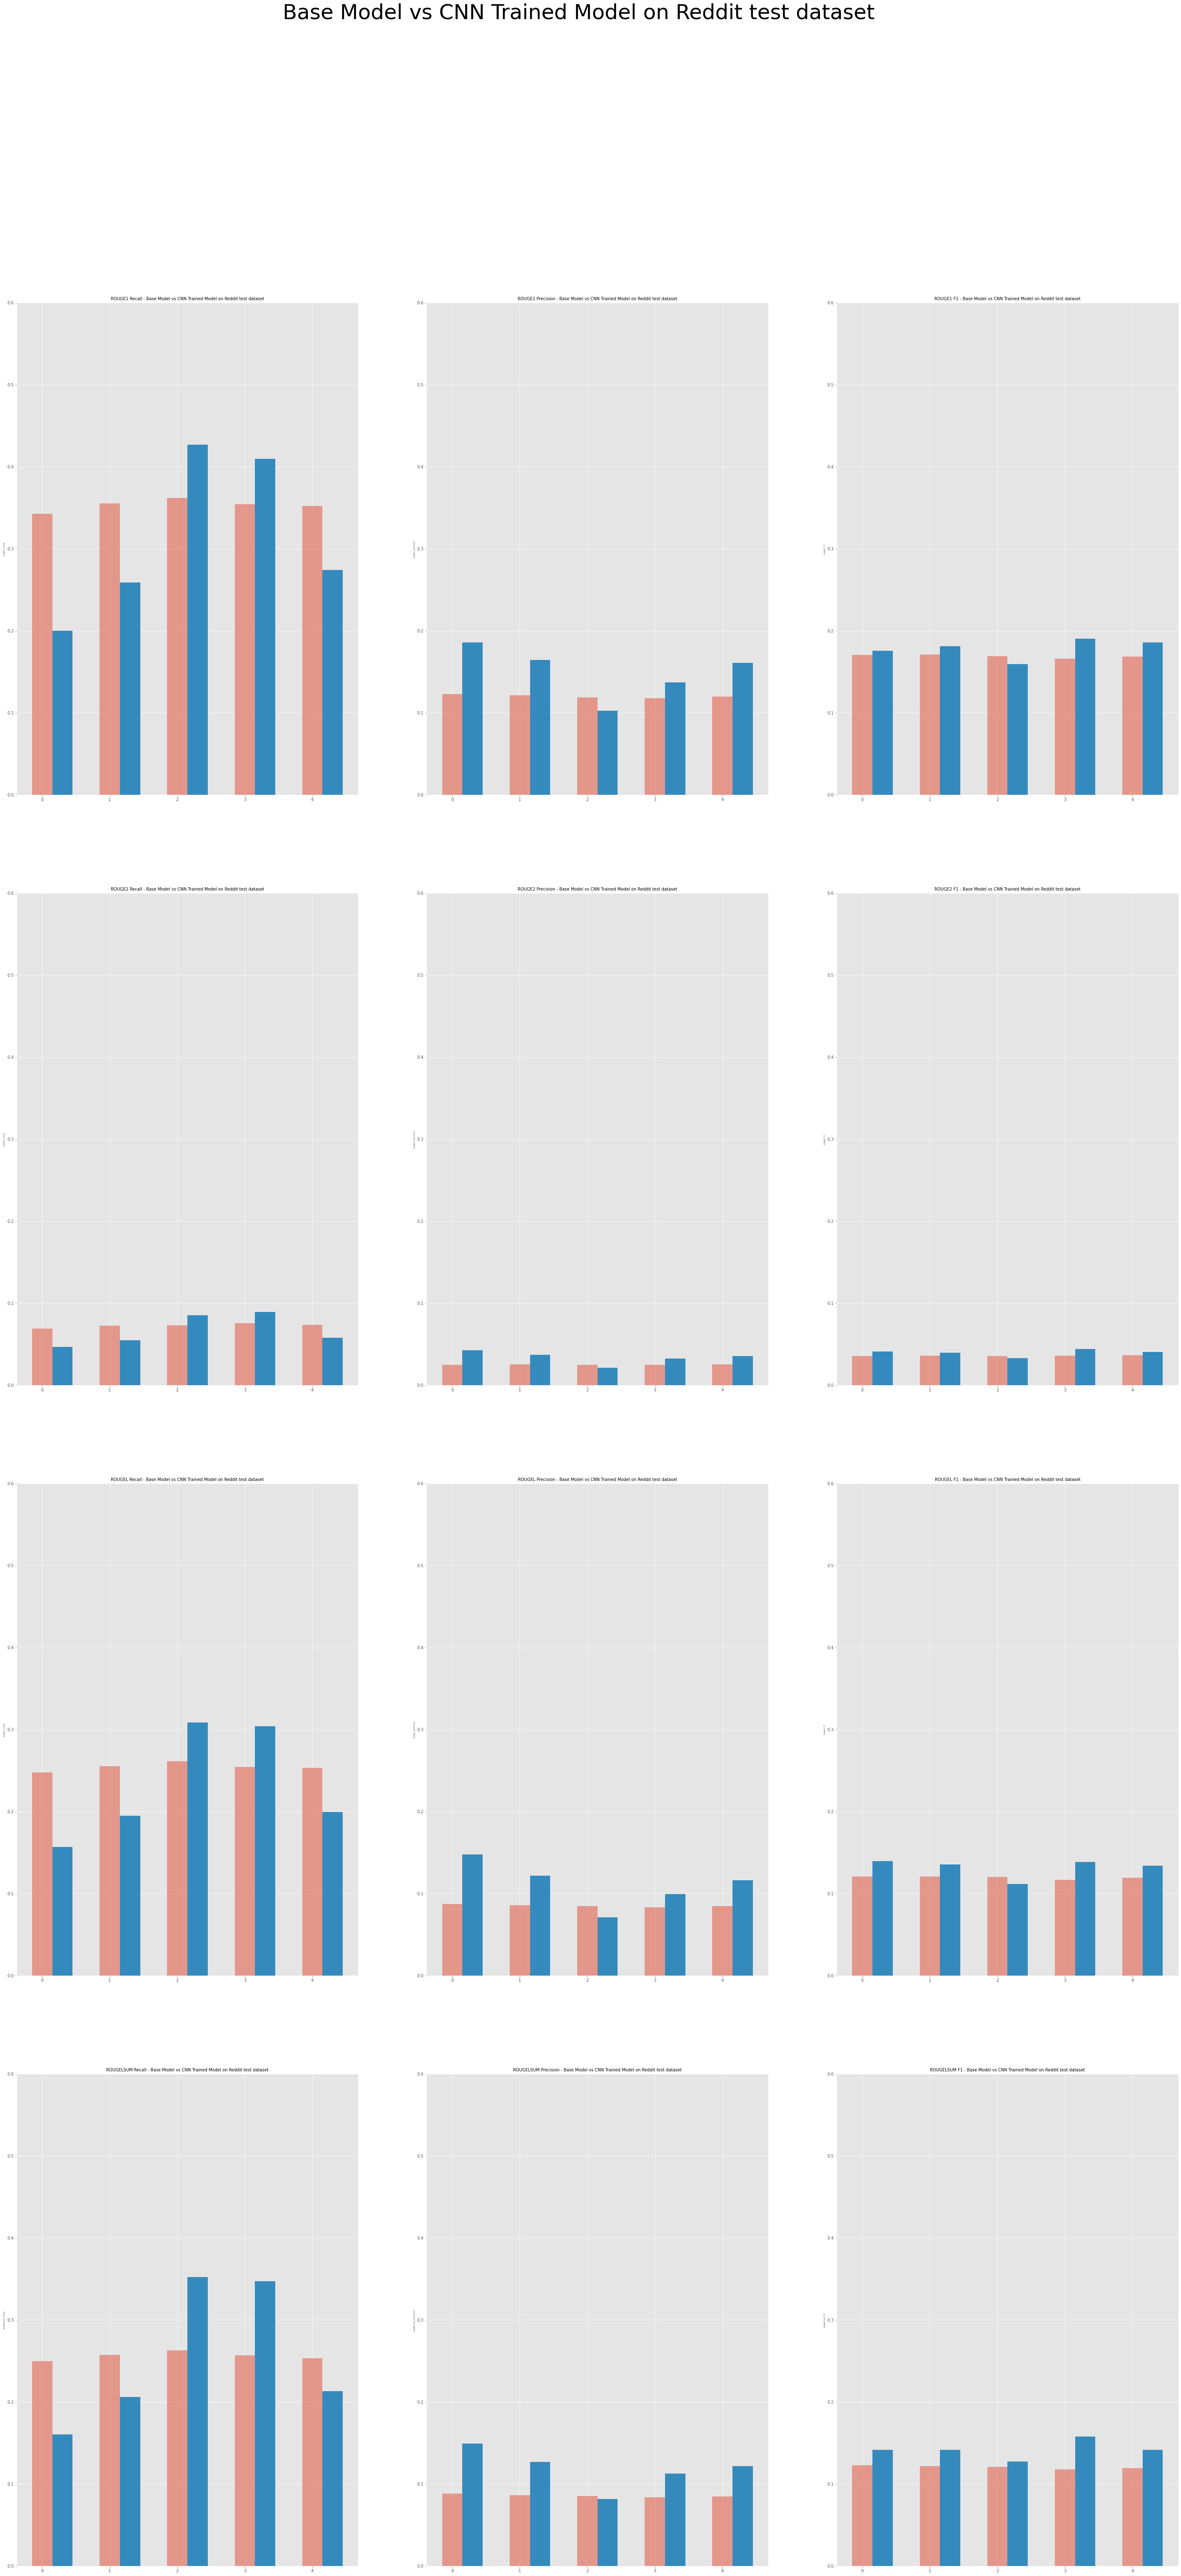

In [ ]:
import pandas as pd

# cnn Model evaluating reddit_tifu dataset

base_reddit_tifu_file_name = "text_metrics-1500000-.test.txt"
base_reddit_tifu_dirs = ['base_reddit_tifu_bs10_ba1', 'base_reddit_tifu_bs10_ba5', 'base_reddit_tifu_bs10_ba9', 'base_reddit_tifu_bs1_ba5', 'base_reddit_tifu_bs5_ba5']
base_reddit_tifu_stats = collectStats(base_reddit_tifu_file_name, base_reddit_tifu_dirs)
print(base_reddit_tifu_stats)

# cnn Model evaluating reddit_tifu dataset
cnn_reddit_tifu_file_name = "text_metrics-210000-.test.txt"
cnn_reddit_tifu_dirs = ['cnn_reddit_tifu_bs10_ba1', 'cnn_reddit_tifu_bs10_ba5', 'cnn_reddit_tifu_bs10_ba9', 'cnn_reddit_tifu_bs1_ba5', 'cnn_reddit_tifu_bs5_ba5']
cnn_reddit_tifu_stats = collectStats(cnn_reddit_tifu_file_name, cnn_reddit_tifu_dirs)
print(cnn_reddit_tifu_stats)

print("\n\nBar Pairs in each subplot represent each experiment varying beam size and beam alpha\n\n\n" )
exp = ['Beam Size 10 and beam alpha 0.1', 'Beam Size 10 and beam alpha 0.5', 
       'Beam Size 10 and beam alpha 0.9', 'Beam Size 1 and beam alpha 0.5', 
       'Beam Size 1 and beam alpha 0.5'] 
print(pd.DataFrame(exp, columns =['Experiments']))    
print("\n\n\n\n")


draw_plots('Base Model vs CNN Trained Model on Reddit test dataset',
           base_reddit_tifu_stats, "Base_Model", cnn_reddit_tifu_stats,
           "CNN_Model", "base_vs_cnn_on_reddit_tifu.png")



Bar Pairs in each subplot represent each experiment varying beam size and beam alpha



                       Experiments
0  Beam Size 10 and beam alpha 0.1
1  Beam Size 10 and beam alpha 0.5
2  Beam Size 10 and beam alpha 0.9
3   Beam Size 1 and beam alpha 0.5
4   Beam Size 1 and beam alpha 0.5







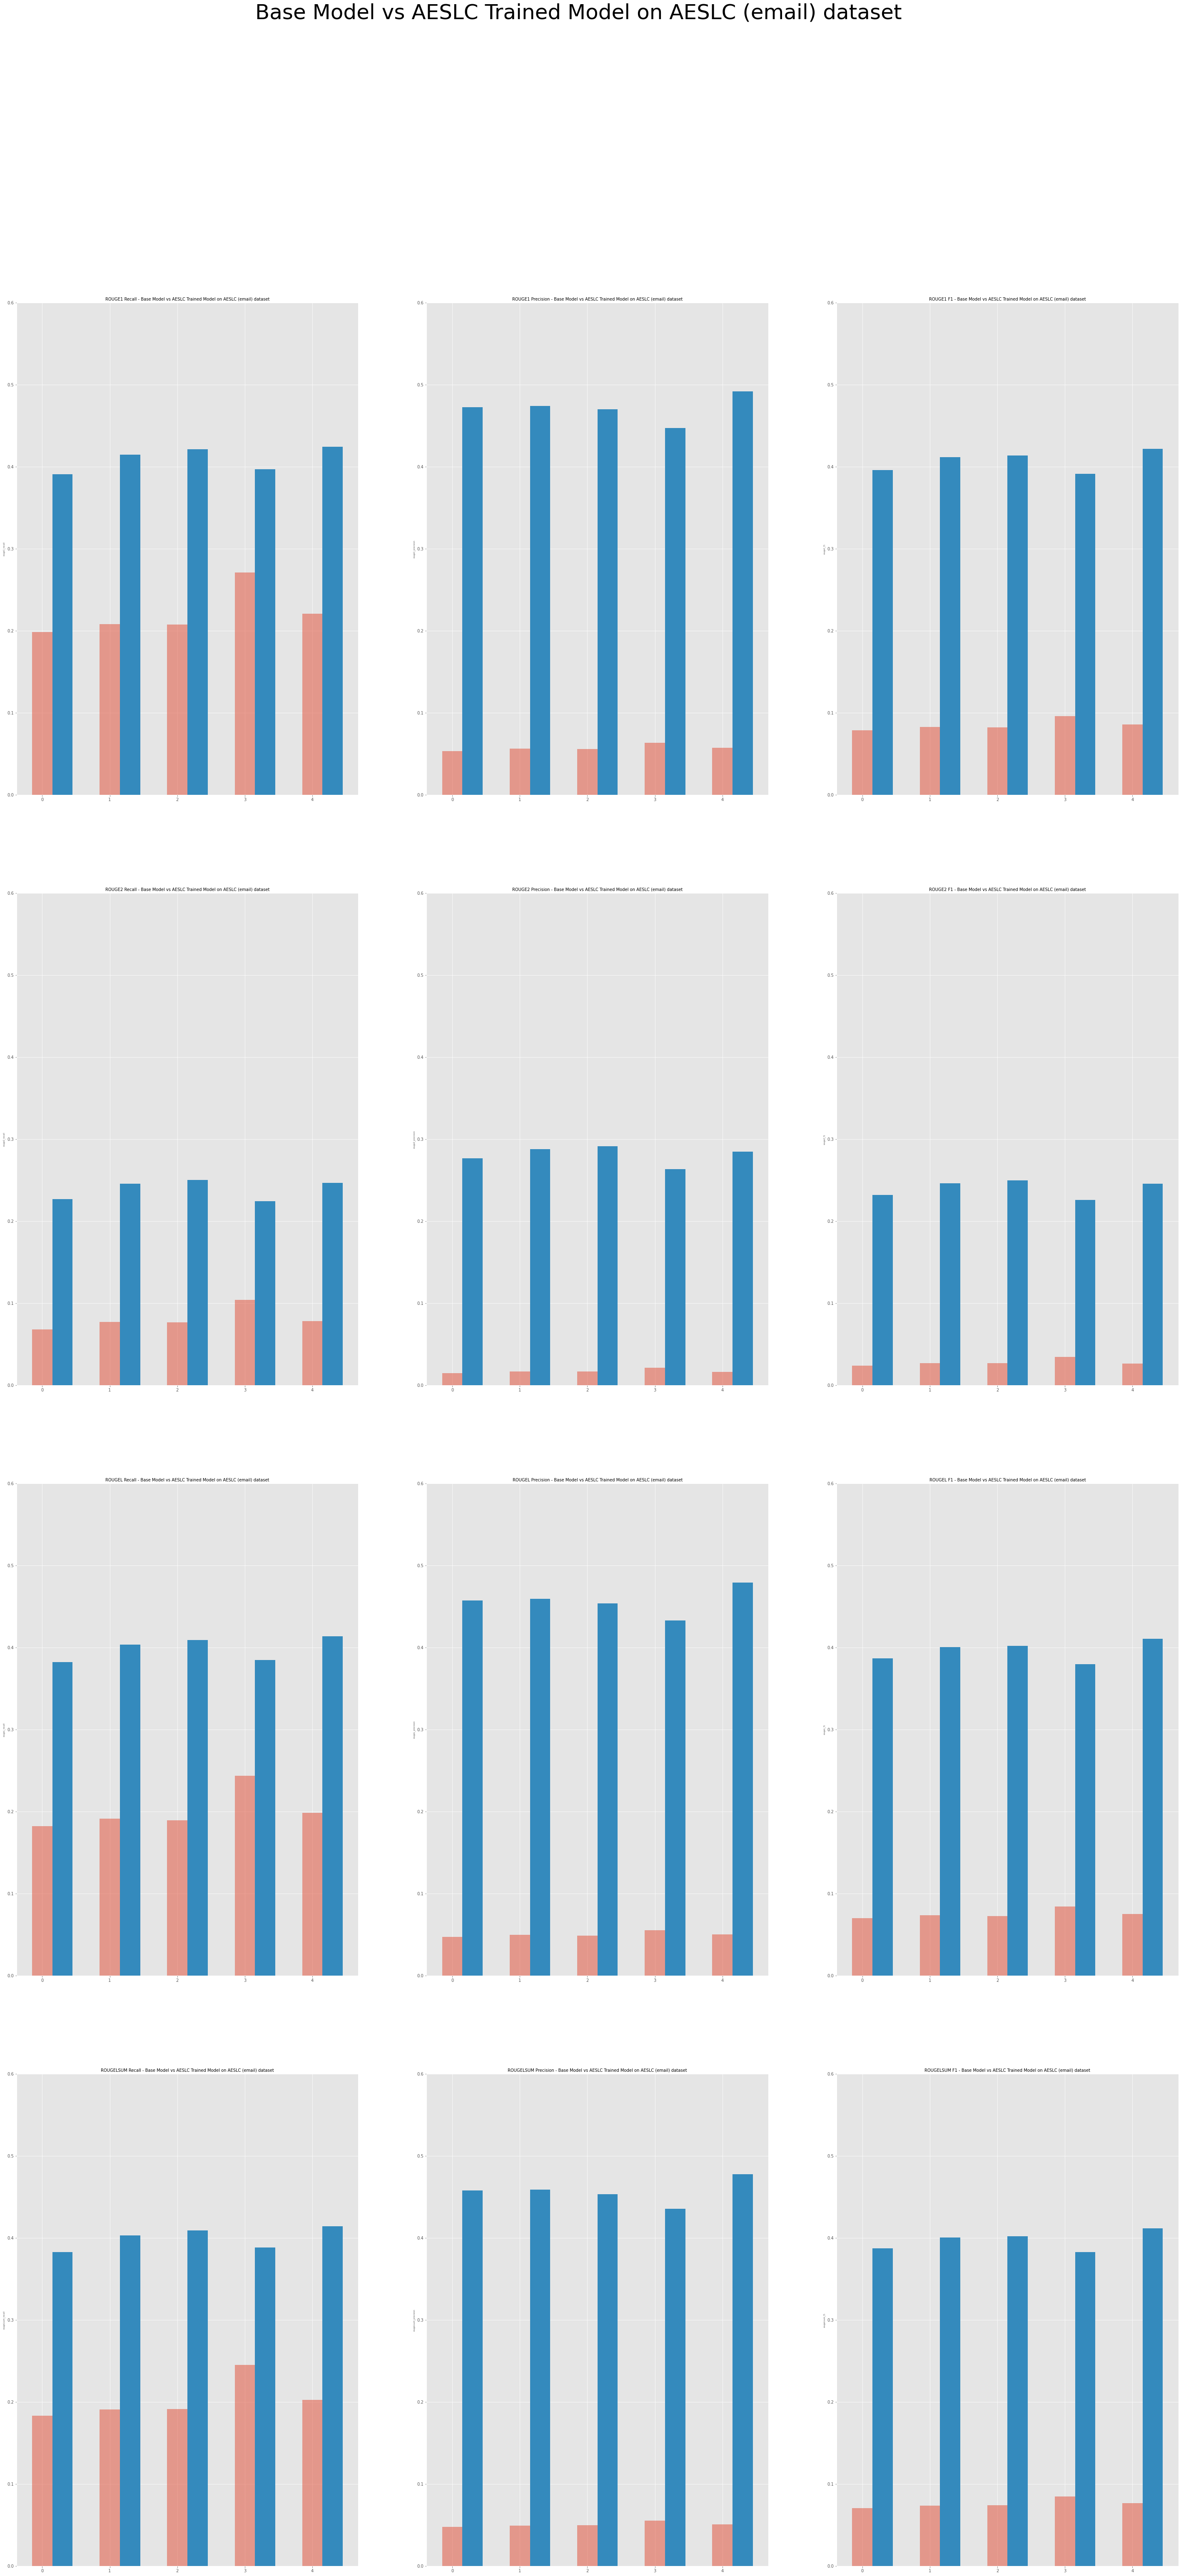

In [ ]:
import pandas as pd
print("\n\nBar Pairs in each subplot represent each experiment varying beam size and beam alpha\n\n\n" )
exp = ['Beam Size 10 and beam alpha 0.1', 'Beam Size 10 and beam alpha 0.5', 
       'Beam Size 10 and beam alpha 0.9', 'Beam Size 1 and beam alpha 0.5', 
       'Beam Size 1 and beam alpha 0.5'] 
print(pd.DataFrame(exp, columns =['Experiments']))    
print("\n\n\n\n")

draw_plots('Base Model vs AESLC Trained Model on AESLC (email) dataset', 
           base_aeslc_stats, "Base_Model", aeslc_aeslc_stats,
           "AESLC_Model", "base_vs_aeslc_on_aeslc.png")

{'rouge1': {'R': {'min': [0.39568400000000004, 0.408533, 0.413804, 0.39516399999999996, 0.399584], 'max': [0.457172, 0.466603, 0.47106400000000004, 0.45764799999999994, 0.46043500000000004], 'avg': [0.424407, 0.437755, 0.441941, 0.42692299999999994, 0.42933999999999994]}, 'P': {'min': [0.293595, 0.282616, 0.27526799999999996, 0.265422, 0.281587], 'max': [0.3497, 0.33402600000000005, 0.32545599999999997, 0.318952, 0.331875], 'avg': [0.320767, 0.306305, 0.298617, 0.29203, 0.306442]}, 'F': {'min': [0.32243299999999997, 0.321873, 0.321885, 0.306215, 0.319966], 'max': [0.36493200000000003, 0.362122, 0.360099, 0.349661, 0.35935900000000004], 'avg': [0.34334000000000003, 0.341648, 0.34124099999999996, 0.327338, 0.340198]}}, 'rouge2': {'R': {'min': [0.14432999999999999, 0.148964, 0.147325, 0.138157, 0.14239100000000002], 'max': [0.19877999999999998, 0.204727, 0.20238399999999998, 0.18953, 0.196772], 'avg': [0.17016199999999998, 0.174574, 0.175003, 0.16309400000000002, 0.167874]}, 'P': {'min': 

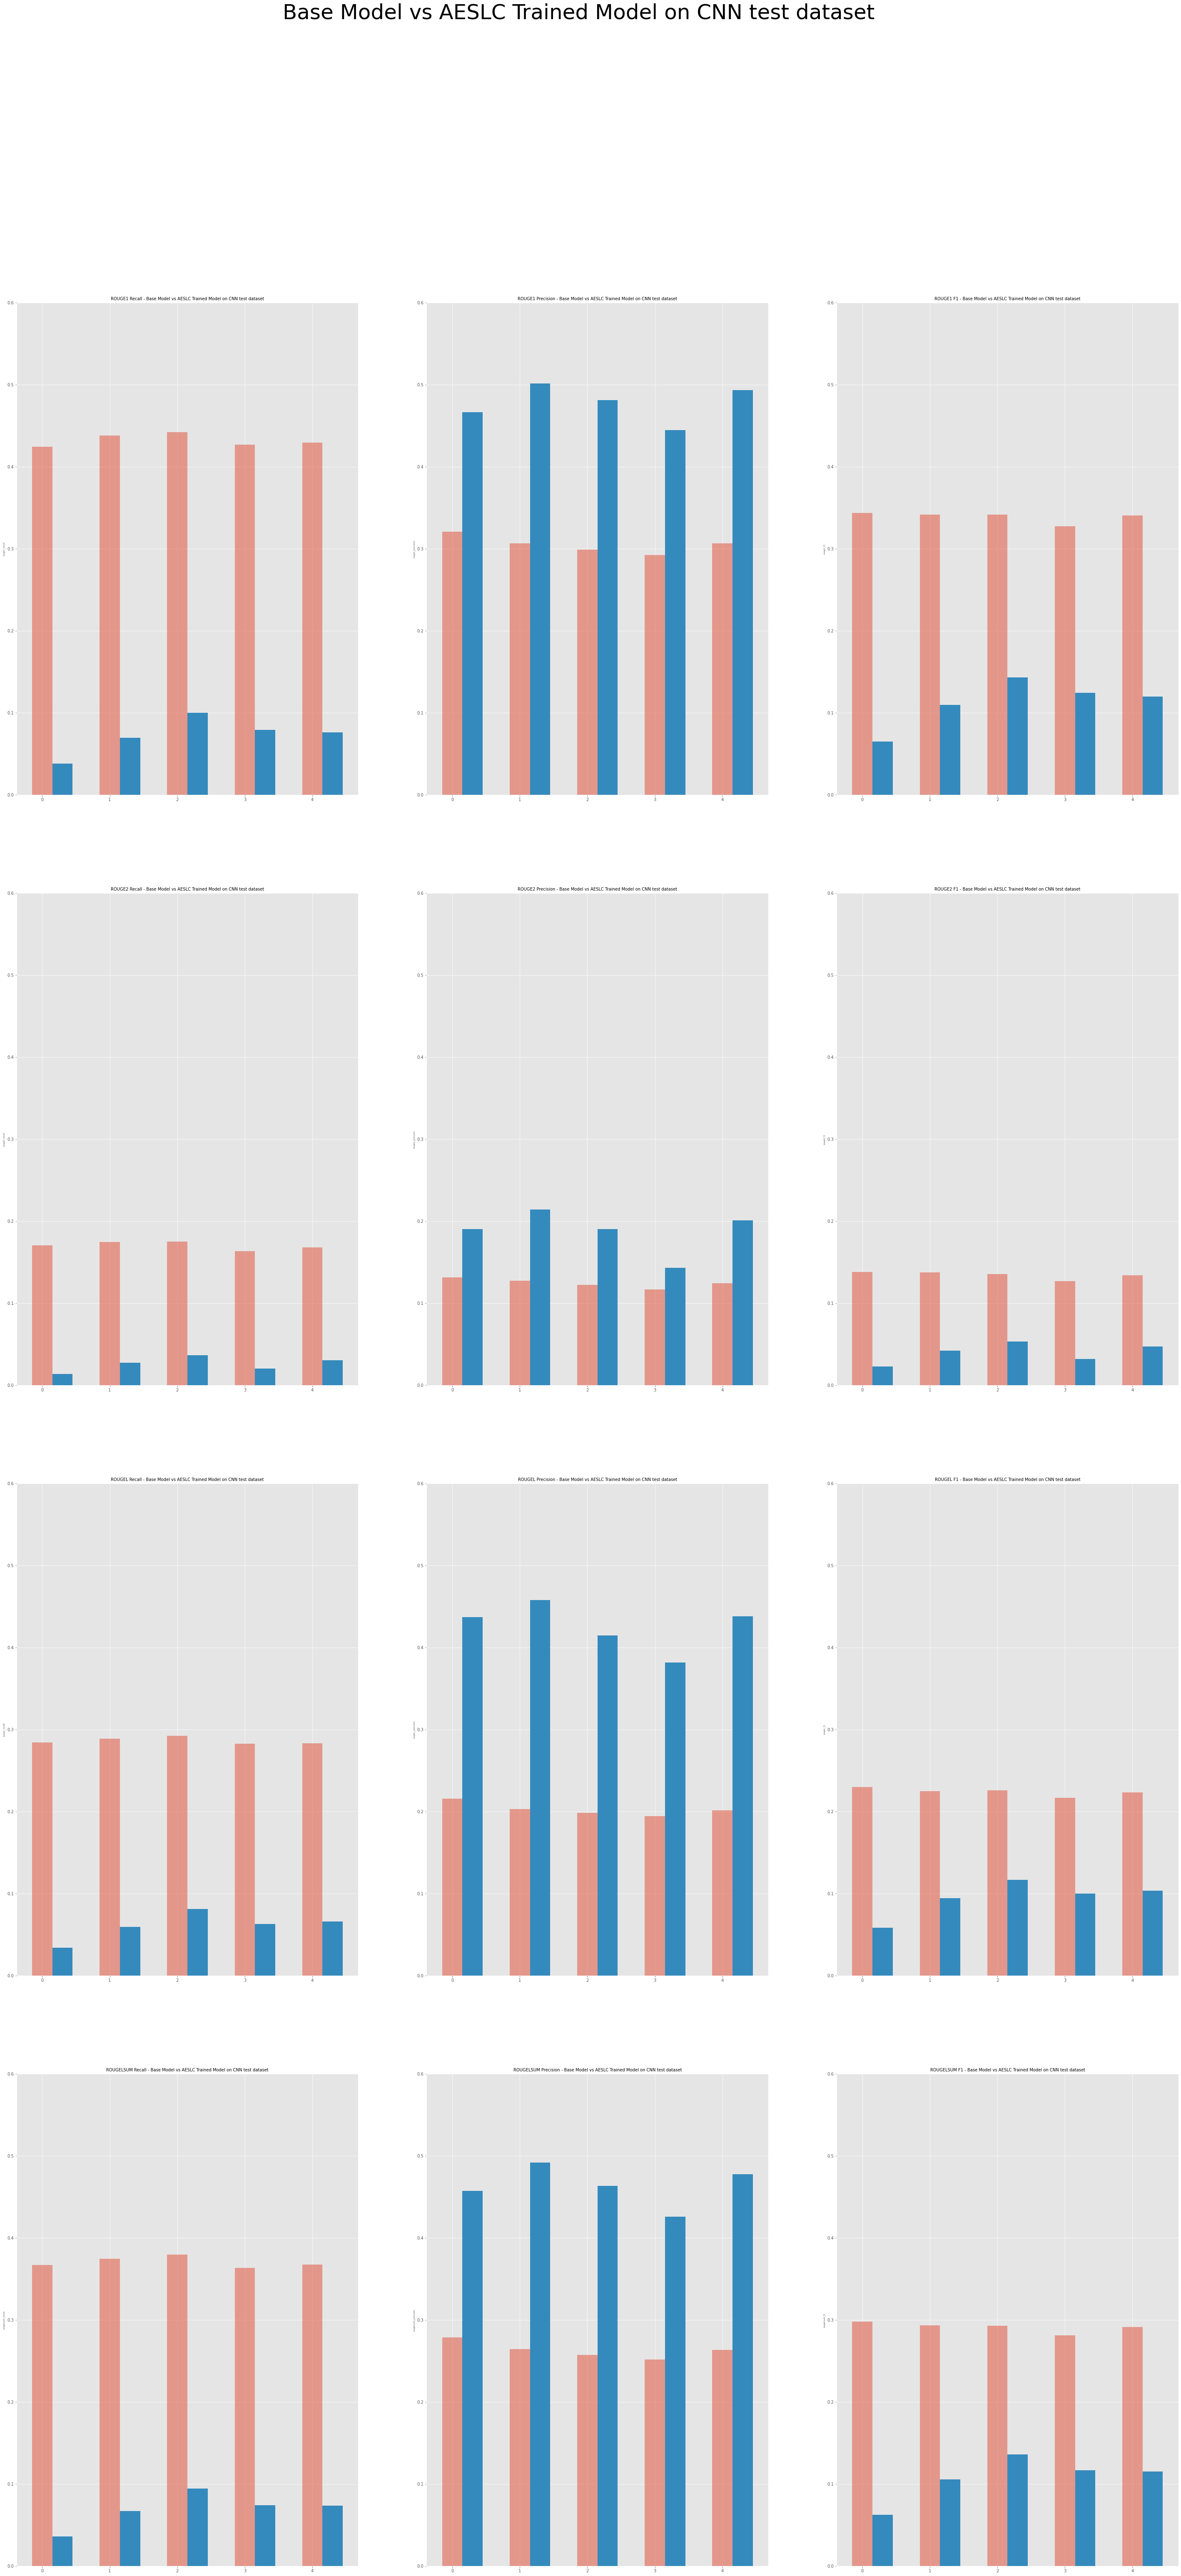

In [ ]:
import pandas as pd

# base Model evaluating cnn dataset

base_cnn_file_name = "text_metrics-1500000-.test.txt"
base_cnn_dirs = ['base_bs10_ba1', 'base_bs10_ba5', 'base_bs10_ba9', 'base_bs1_ba5', 'base_bs5_ba5']
base_cnn_stats = collectStats(base_cnn_file_name, base_cnn_dirs)
print(base_cnn_stats)

# aeslc Model evaluating cnn dataset
aeslc_cnn_file_name = "text_metrics-32000-.test.txt"
aeslc_cnn_dirs = ['aeslc_cnn_bs10_ba1', 'aeslc_cnn_bs10_ba5', 'aeslc_cnn_bs10_ba9', 'aeslc_cnn_bs1_ba5', 'aeslc_cnn_bs5_ba5']
aeslc_cnn_stats = collectStats(aeslc_cnn_file_name, aeslc_cnn_dirs)
print(aeslc_cnn_stats)

print("\n\nBar Pairs in each subplot represent each experiment varying beam size and beam alpha\n\n\n" )
exp = ['Beam Size 10 and beam alpha 0.1', 'Beam Size 10 and beam alpha 0.5', 
       'Beam Size 10 and beam alpha 0.9', 'Beam Size 1 and beam alpha 0.5', 
       'Beam Size 1 and beam alpha 0.5'] 
print(pd.DataFrame(exp, columns =['Experiments']))    
print("\n\n\n\n")


draw_plots('Base Model vs AESLC Trained Model on CNN test dataset',
           base_cnn_stats, "Base_Model", aeslc_cnn_stats,
           "aeslc_Model", "base_vs_aeslc_on_cnn.png")



{'rouge1': {'R': {'min': [0.30850500000000003, 0.321691, 0.32618800000000003, 0.321317, 0.315535], 'max': [0.374316, 0.388652, 0.394625, 0.390104, 0.384908], 'avg': [0.342308, 0.35512, 0.362016, 0.354214, 0.352254]}, 'P': {'min': [0.107396, 0.104289, 0.103372, 0.10217000000000001, 0.103904], 'max': [0.138977, 0.138261, 0.133218, 0.135018, 0.135179], 'avg': [0.12263399999999999, 0.121178, 0.118519, 0.117574, 0.119433]}, 'F': {'min': [0.15168900000000002, 0.15021500000000002, 0.149927, 0.14693699999999998, 0.149411], 'max': [0.191131, 0.192146, 0.186792, 0.18672, 0.18782000000000001], 'avg': [0.17033099999999998, 0.170958, 0.16894, 0.165726, 0.168495]}}, 'rouge2': {'R': {'min': [0.050347, 0.054572, 0.054285, 0.057135000000000005, 0.054527], 'max': [0.09093, 0.09377, 0.093092, 0.097997, 0.095028], 'avg': [0.068655, 0.072403, 0.07291399999999999, 0.07521, 0.073486]}, 'P': {'min': [0.017755, 0.018365, 0.018108000000000003, 0.017855000000000003, 0.017935], 'max': [0.033808, 0.033688, 0.03294

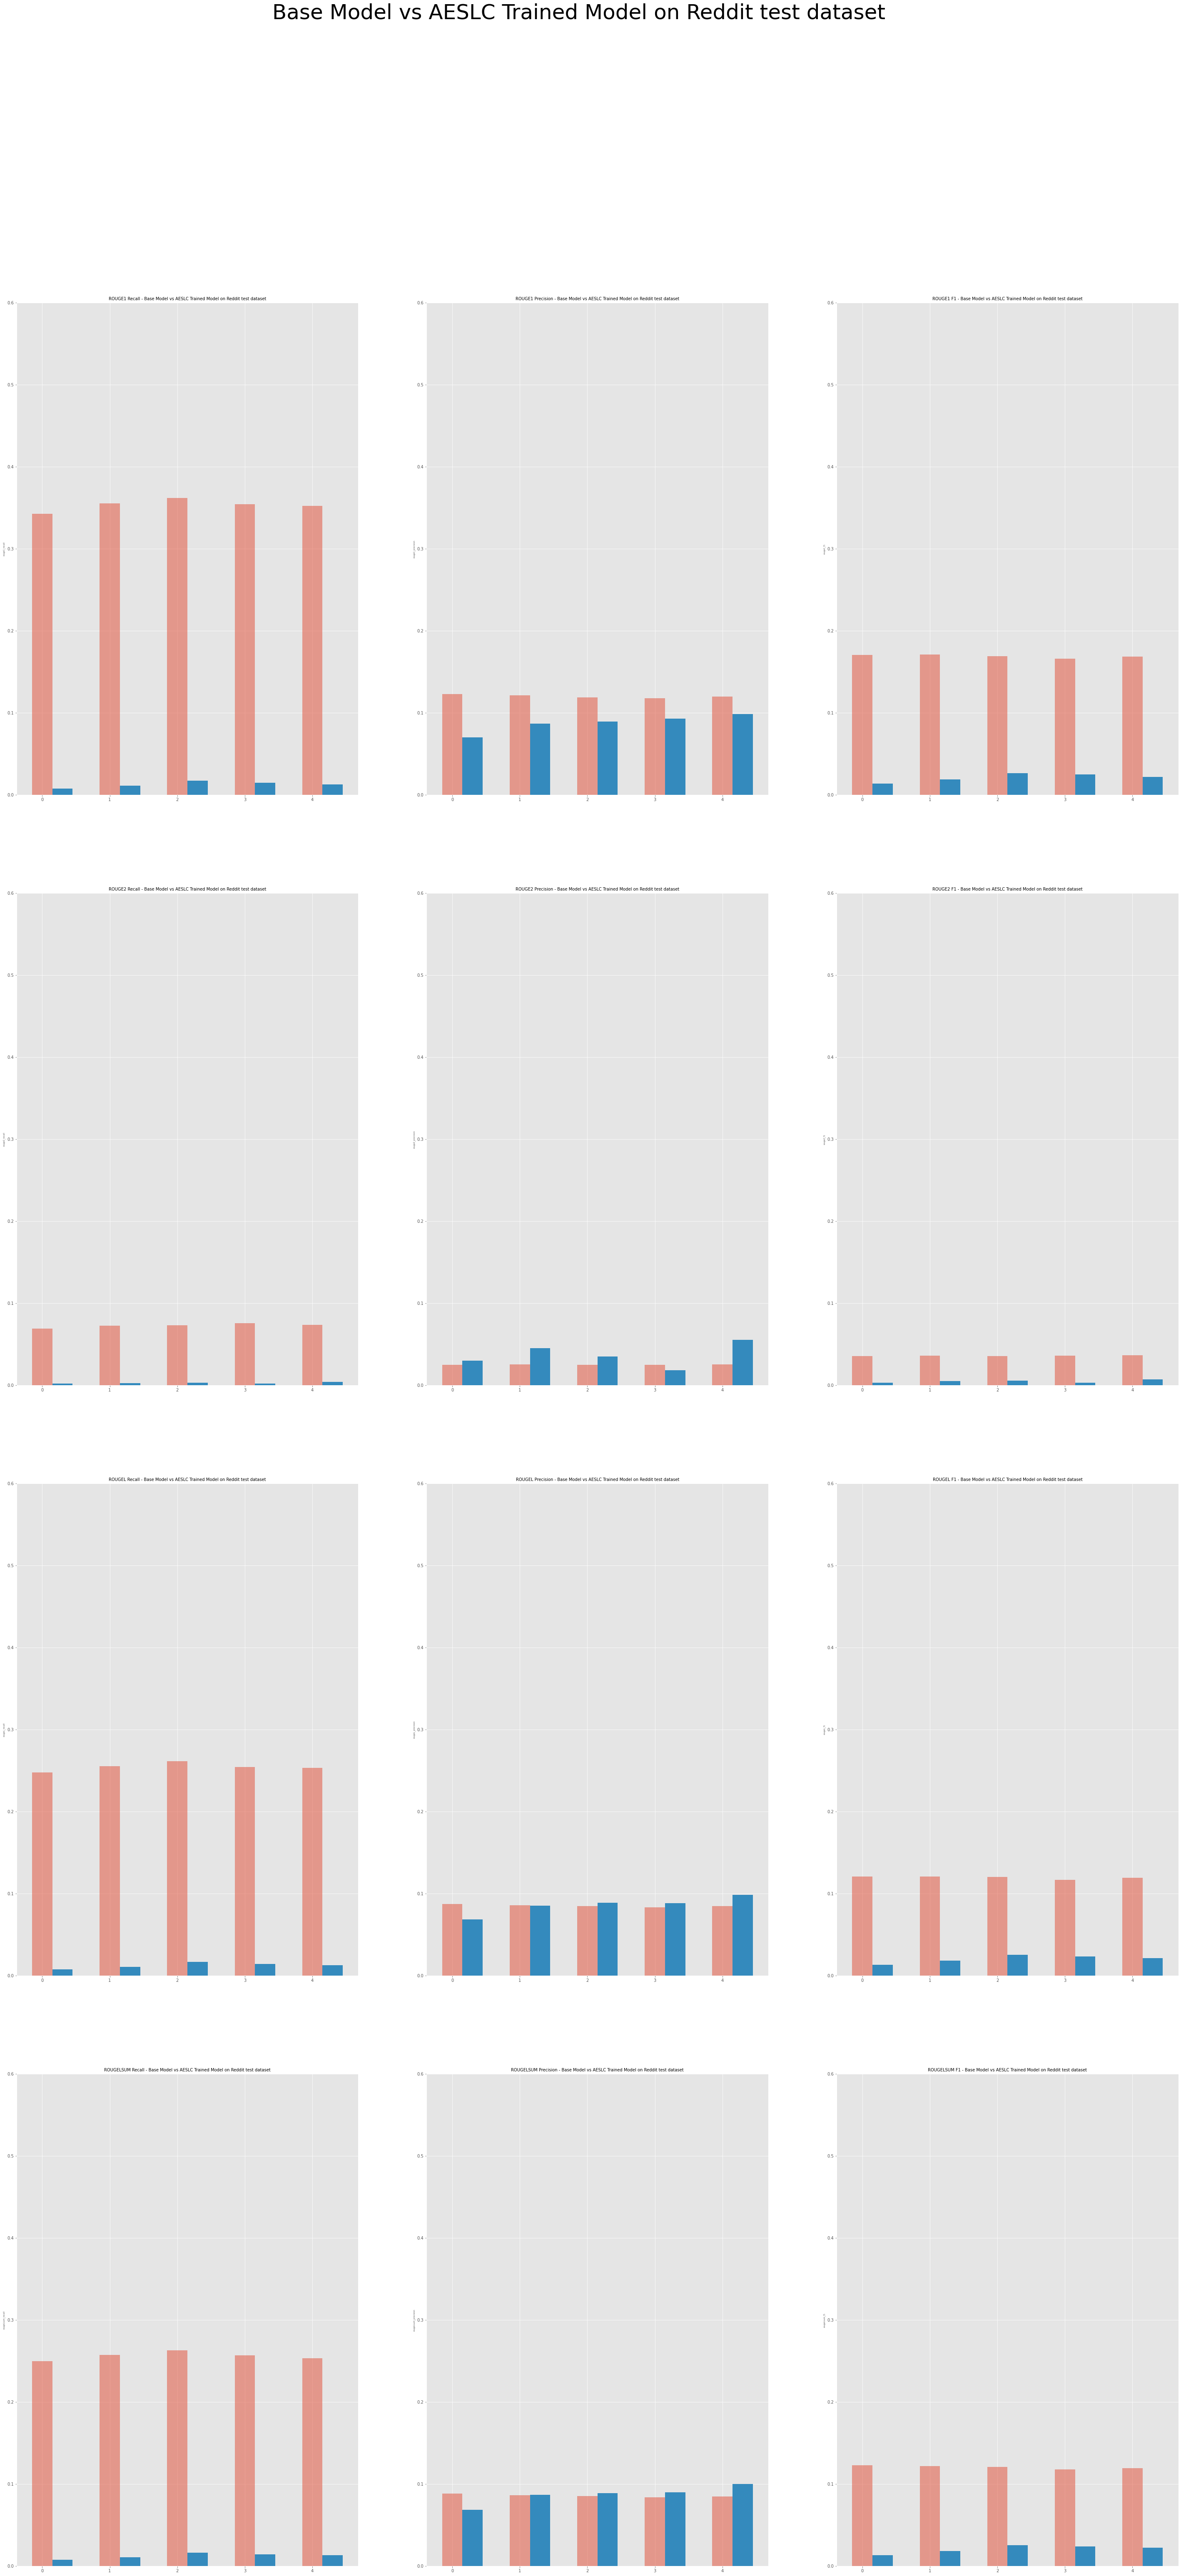

In [ ]:
import pandas as pd

# base Model evaluating reddit_tifu dataset

base_reddit_tifu_file_name = "text_metrics-1500000-.test.txt"
base_reddit_tifu_dirs = ['base_reddit_tifu_bs10_ba1', 'base_reddit_tifu_bs10_ba5', 'base_reddit_tifu_bs10_ba9', 'base_reddit_tifu_bs1_ba5', 'base_reddit_tifu_bs5_ba5']
base_reddit_tifu_stats = collectStats(base_reddit_tifu_file_name, base_reddit_tifu_dirs)
print(base_reddit_tifu_stats)

# aeslc Model evaluating reddit_tifu dataset
aeslc_reddit_tifu_file_name = "text_metrics-32000-.test.txt"
aeslc_reddit_tifu_dirs = ['aeslc_reddit_tifu_bs10_ba1', 'aeslc_reddit_tifu_bs10_ba5', 'aeslc_reddit_tifu_bs10_ba9', 'aeslc_reddit_tifu_bs1_ba5', 'aeslc_reddit_tifu_bs5_ba5']
aeslc_reddit_tifu_stats = collectStats(aeslc_reddit_tifu_file_name, aeslc_reddit_tifu_dirs)
print(aeslc_reddit_tifu_stats)

print("\n\nBar Pairs in each subplot represent each experiment varying beam size and beam alpha\n\n\n" )
exp = ['Beam Size 10 and beam alpha 0.1', 'Beam Size 10 and beam alpha 0.5', 
       'Beam Size 10 and beam alpha 0.9', 'Beam Size 1 and beam alpha 0.5', 
       'Beam Size 1 and beam alpha 0.5'] 
print(pd.DataFrame(exp, columns =['Experiments']))    
print("\n\n\n\n")


draw_plots('Base Model vs AESLC Trained Model on Reddit test dataset',
           base_reddit_tifu_stats, "Base_Model", aeslc_reddit_tifu_stats,
           "aeslc_Model", "base_vs_aeslc_on_reddit_tifu.png")



{'rouge1': {'R': {'min': [0.150371, 0.194432, 0.230267, 0.23141599999999998, 0.208207], 'max': [0.196347, 0.24493800000000002, 0.278918, 0.277136, 0.25542], 'avg': [0.17219, 0.218935, 0.25438099999999997, 0.254882, 0.23054499999999997]}, 'P': {'min': [0.403484, 0.292605, 0.212376, 0.186792, 0.273556], 'max': [0.48114300000000004, 0.36624, 0.27068600000000004, 0.23960700000000001, 0.35440900000000003], 'avg': [0.44276000000000004, 0.330098, 0.24027199999999999, 0.21235500000000002, 0.314652]}, 'F': {'min': [0.200232, 0.201647, 0.200249, 0.189054, 0.204546], 'max': [0.246121, 0.24303200000000003, 0.241666, 0.232026, 0.24612199999999998], 'avg': [0.221898, 0.22184099999999998, 0.22094699999999998, 0.21057199999999998, 0.225282]}}, 'rouge2': {'R': {'min': [0.047727, 0.051346, 0.058275, 0.049602, 0.051167000000000004], 'max': [0.074379, 0.07914199999999999, 0.085487, 0.069373, 0.07750900000000001], 'avg': [0.060004999999999996, 0.064928, 0.070772, 0.059739999999999994, 0.063372]}, 'P': {'mi

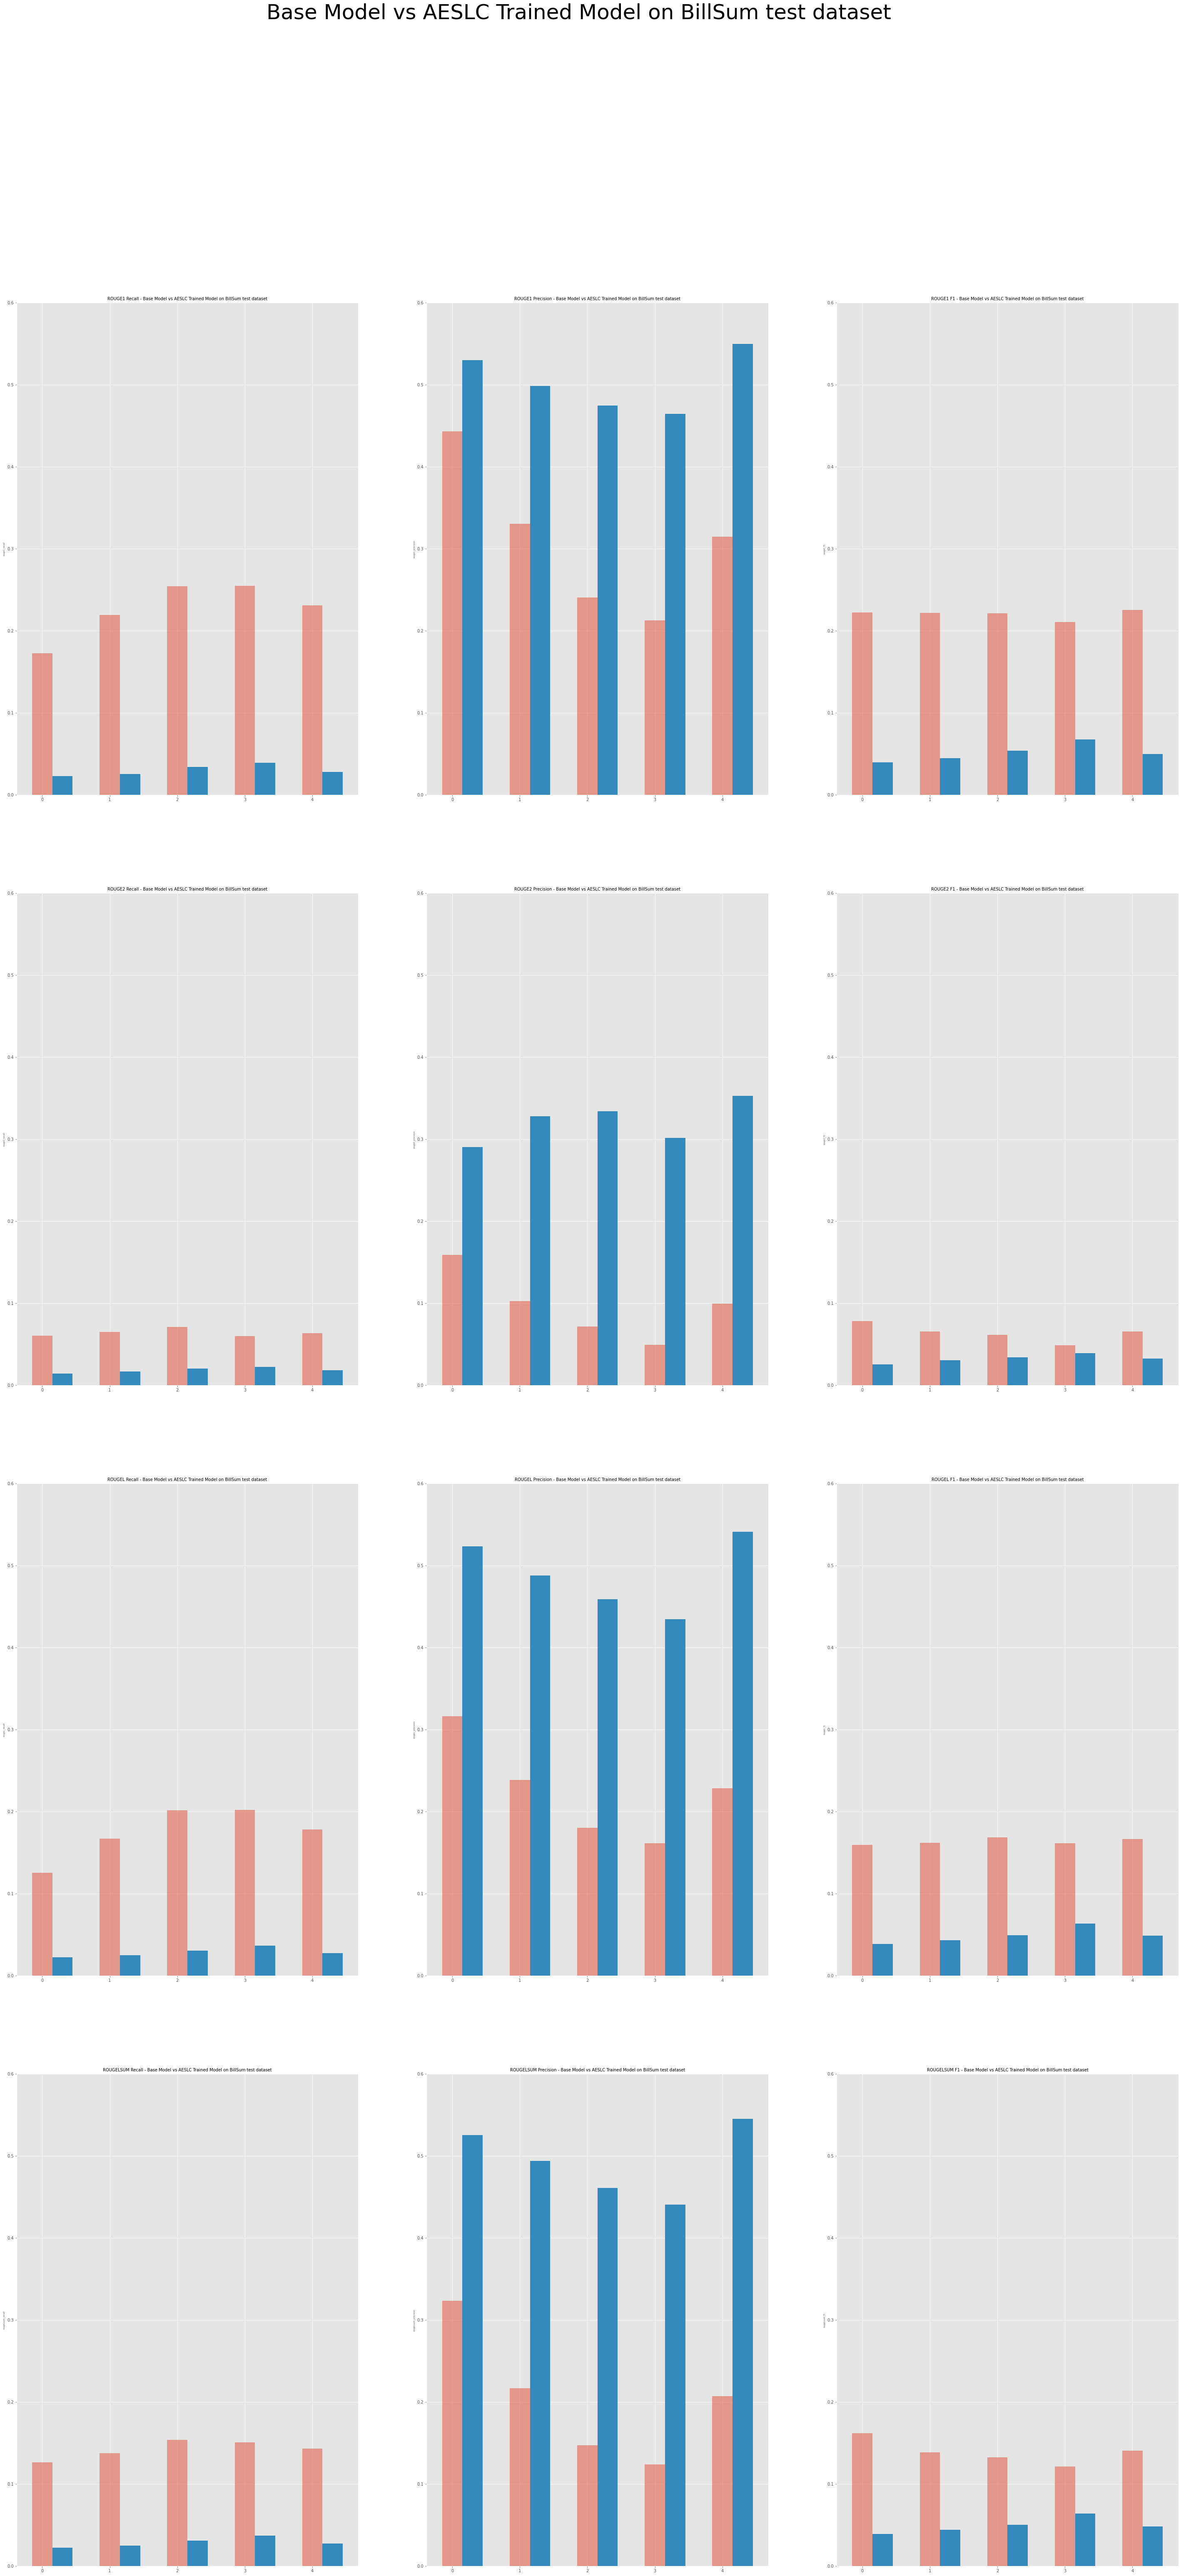

In [ ]:
import pandas as pd

# base Model evaluating billsum dataset

base_billsum_file_name = "text_metrics-1500000-.test.txt"
base_billsum_dirs = ['base_billsum_bs10_ba1', 'base_billsum_bs10_ba5', 'base_billsum_bs10_ba9', 'base_billsum_bs1_ba5', 'base_billsum_bs5_ba5']
base_billsum_stats = collectStats(base_billsum_file_name, base_billsum_dirs)
print(base_billsum_stats)

# aeslc Model evaluating billsum dataset
aeslc_billsum_file_name = "text_metrics-32000-.test.txt"
aeslc_billsum_dirs = ['aeslc_billsum_bs10_ba1', 'aeslc_billsum_bs10_ba5', 'aeslc_billsum_bs10_ba9', 'aeslc_billsum_bs1_ba5', 'aeslc_billsum_bs5_ba5']
aeslc_billsum_stats = collectStats(aeslc_billsum_file_name, aeslc_billsum_dirs)
print(aeslc_billsum_stats)

print("\n\nBar Pairs in each subplot represent each experiment varying beam size and beam alpha\n\n\n" )
exp = ['Beam Size 10 and beam alpha 0.1', 'Beam Size 10 and beam alpha 0.5', 
       'Beam Size 10 and beam alpha 0.9', 'Beam Size 1 and beam alpha 0.5', 
       'Beam Size 1 and beam alpha 0.5'] 
print(pd.DataFrame(exp, columns =['Experiments']))    
print("\n\n\n\n")


draw_plots('Base Model vs AESLC Trained Model on BillSum test dataset',
           base_billsum_stats, "Base_Model", aeslc_billsum_stats,
           "aeslc_Model", "base_vs_aeslc_on_billsum.png")


{'rouge1': {'R': {'min': [0.39568400000000004, 0.408533, 0.413804, 0.39516399999999996, 0.399584], 'max': [0.457172, 0.466603, 0.47106400000000004, 0.45764799999999994, 0.46043500000000004], 'avg': [0.424407, 0.437755, 0.441941, 0.42692299999999994, 0.42933999999999994]}, 'P': {'min': [0.293595, 0.282616, 0.27526799999999996, 0.265422, 0.281587], 'max': [0.3497, 0.33402600000000005, 0.32545599999999997, 0.318952, 0.331875], 'avg': [0.320767, 0.306305, 0.298617, 0.29203, 0.306442]}, 'F': {'min': [0.32243299999999997, 0.321873, 0.321885, 0.306215, 0.319966], 'max': [0.36493200000000003, 0.362122, 0.360099, 0.349661, 0.35935900000000004], 'avg': [0.34334000000000003, 0.341648, 0.34124099999999996, 0.327338, 0.340198]}}, 'rouge2': {'R': {'min': [0.14432999999999999, 0.148964, 0.147325, 0.138157, 0.14239100000000002], 'max': [0.19877999999999998, 0.204727, 0.20238399999999998, 0.18953, 0.196772], 'avg': [0.17016199999999998, 0.174574, 0.175003, 0.16309400000000002, 0.167874]}, 'P': {'min': 

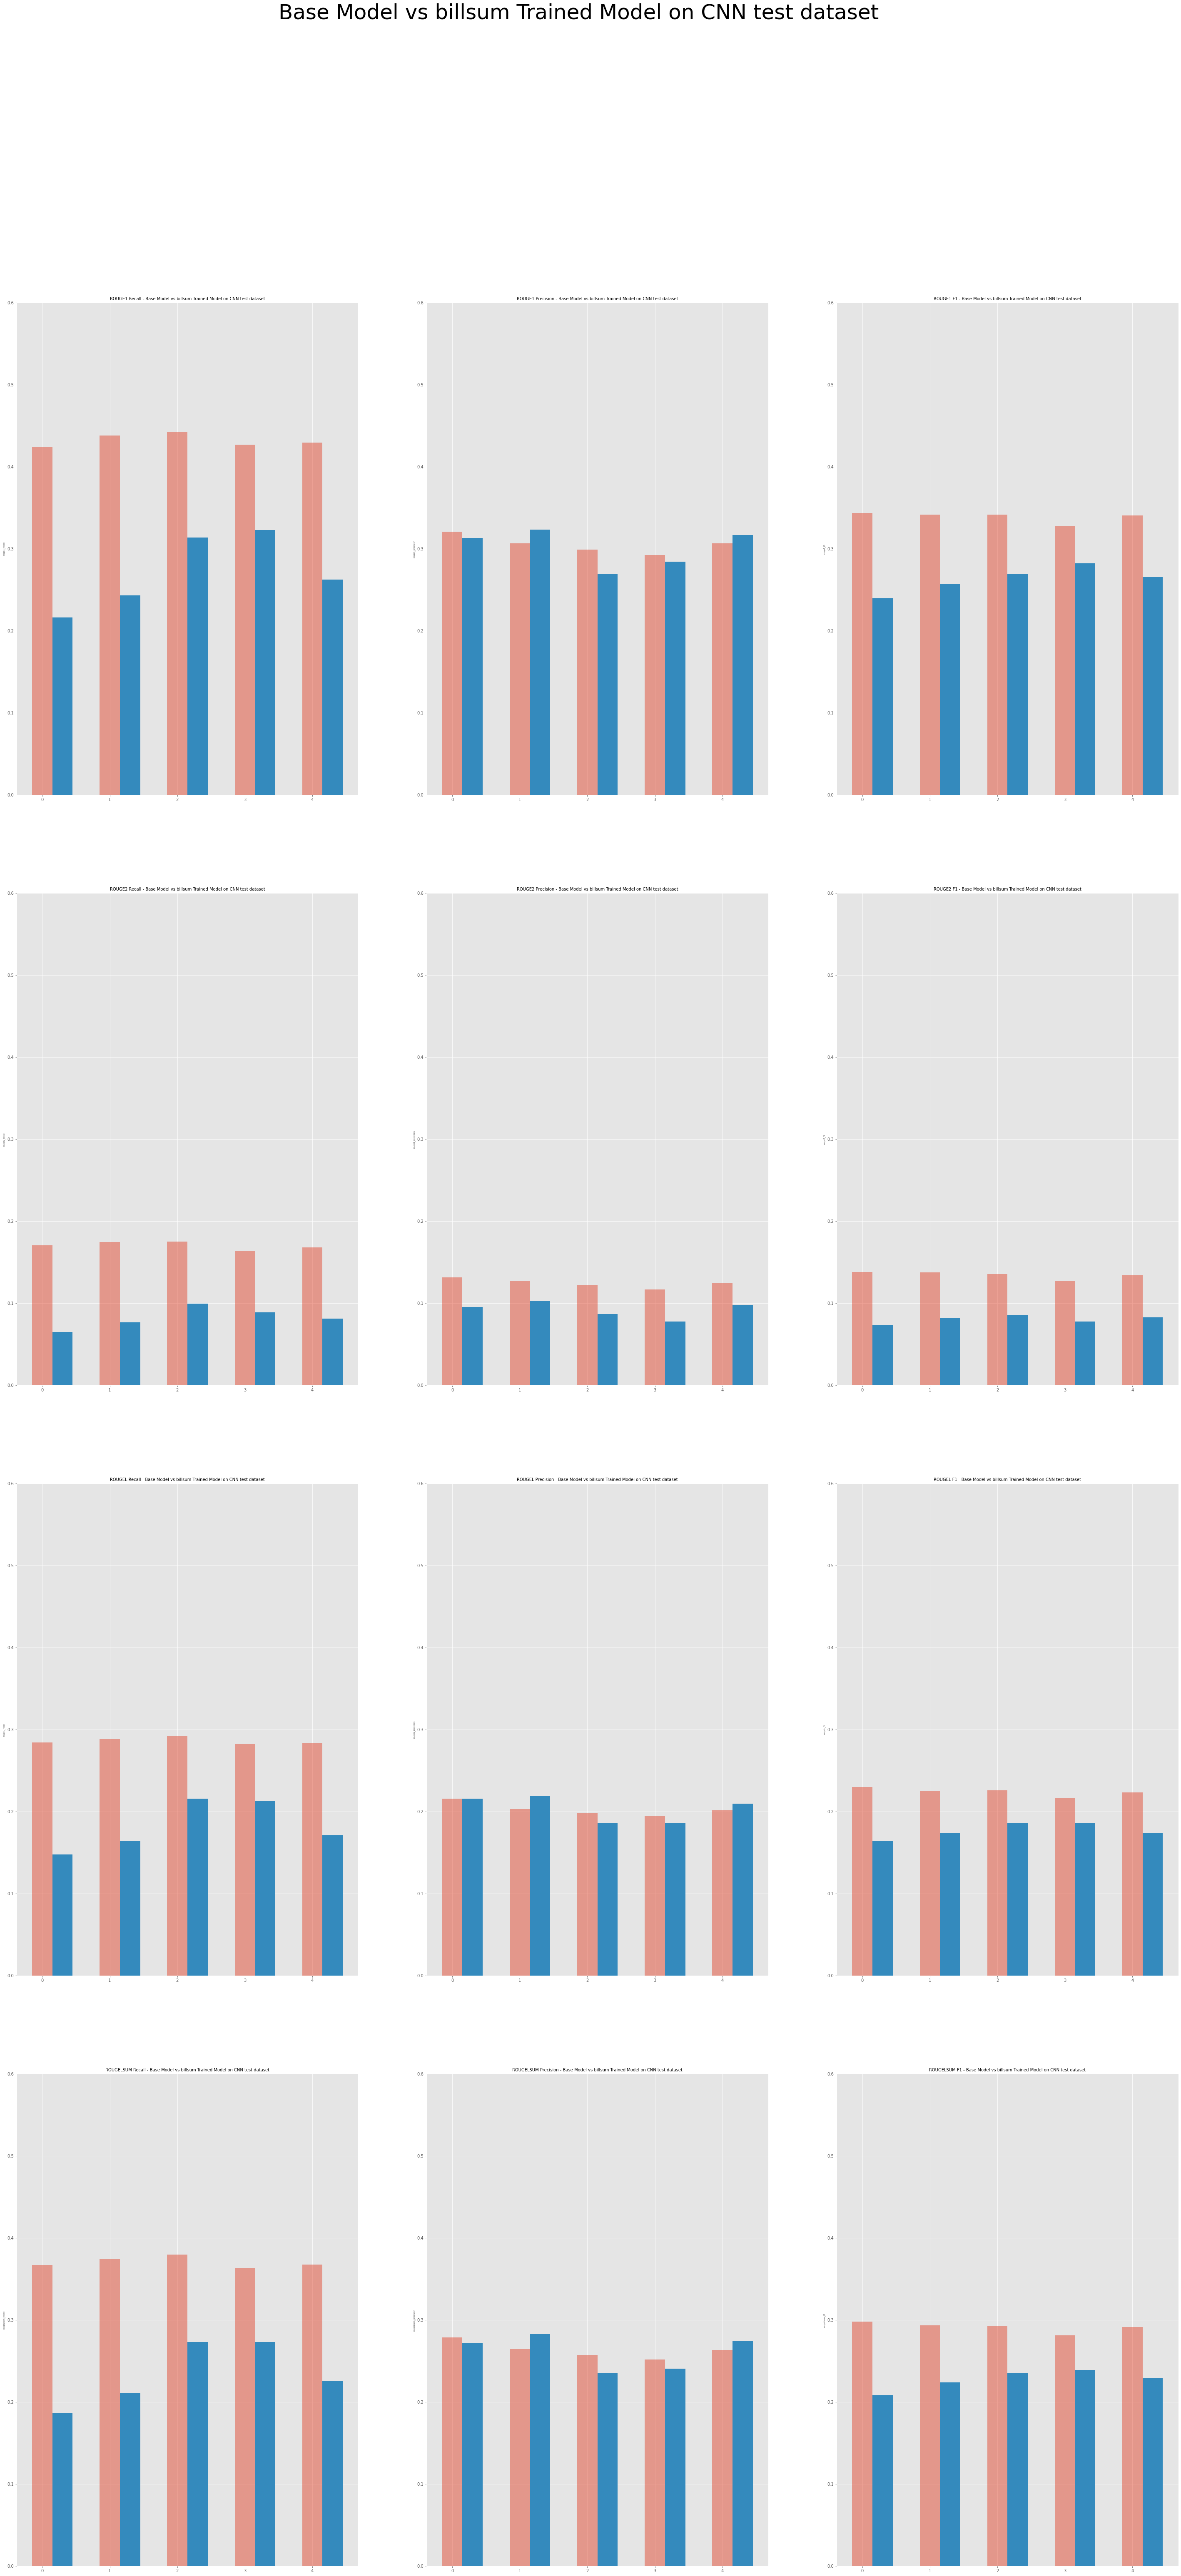

In [ ]:
import pandas as pd

# base Model evaluating cnn dataset

base_cnn_file_name = "text_metrics-1500000-.test.txt"
base_cnn_dirs = ['base_bs10_ba1', 'base_bs10_ba5', 'base_bs10_ba9', 'base_bs1_ba5', 'base_bs5_ba5']
base_cnn_stats = collectStats(base_cnn_file_name, base_cnn_dirs)
print(base_cnn_stats)

# billsum Model evaluating cnn dataset
billsum_cnn_file_name = "text_metrics-180000-.test.txt"
billsum_cnn_dirs = ['billsum_cnn_bs10_ba1', 'billsum_cnn_bs10_ba5', 'billsum_cnn_bs10_ba9', 'billsum_cnn_bs1_ba5', 'billsum_cnn_bs5_ba5']
billsum_cnn_stats = collectStats(billsum_cnn_file_name, billsum_cnn_dirs)
print(billsum_cnn_stats)

print("\n\nBar Pairs in each subplot represent each experiment varying beam size and beam alpha\n\n\n" )
exp = ['Beam Size 10 and beam alpha 0.1', 'Beam Size 10 and beam alpha 0.5', 
       'Beam Size 10 and beam alpha 0.9', 'Beam Size 1 and beam alpha 0.5', 
       'Beam Size 1 and beam alpha 0.5'] 
print(pd.DataFrame(exp, columns =['Experiments']))    
print("\n\n\n\n")


draw_plots('Base Model vs billsum Trained Model on CNN test dataset',
           base_cnn_stats, "Base_Model", billsum_cnn_stats,
           "billsum_Model", "base_vs_billsum_on_cnn.png")



{'rouge1': {'R': {'min': [0.139295, 0.149538, 0.147753, 0.211416, 0.162476], 'max': [0.26287699999999997, 0.268714, 0.26551199999999997, 0.33824299999999996, 0.2864], 'avg': [0.19817, 0.20780900000000002, 0.20725100000000002, 0.270848, 0.22044899999999998]}, 'P': {'min': [0.036884, 0.038734, 0.038982, 0.047636000000000005, 0.040839], 'max': [0.072825, 0.074931, 0.074602, 0.08240399999999999, 0.076652], 'avg': [0.053183, 0.055915999999999993, 0.055547000000000006, 0.063172, 0.057293]}, 'F': {'min': [0.055686, 0.057482000000000005, 0.058753, 0.073353, 0.061698], 'max': [0.105549, 0.107971, 0.10818699999999999, 0.123089, 0.11377999999999999], 'avg': [0.078559, 0.082444, 0.082163, 0.09586900000000001, 0.08580299999999999]}}, 'rouge2': {'R': {'min': [0.032255, 0.039819, 0.037247, 0.05754, 0.039667], 'max': [0.115699, 0.123376, 0.12898099999999998, 0.15317, 0.126167], 'avg': [0.067643, 0.076964, 0.076512, 0.10403599999999999, 0.078226]}, 'P': {'min': [0.006987999999999999, 0.008428, 0.008048

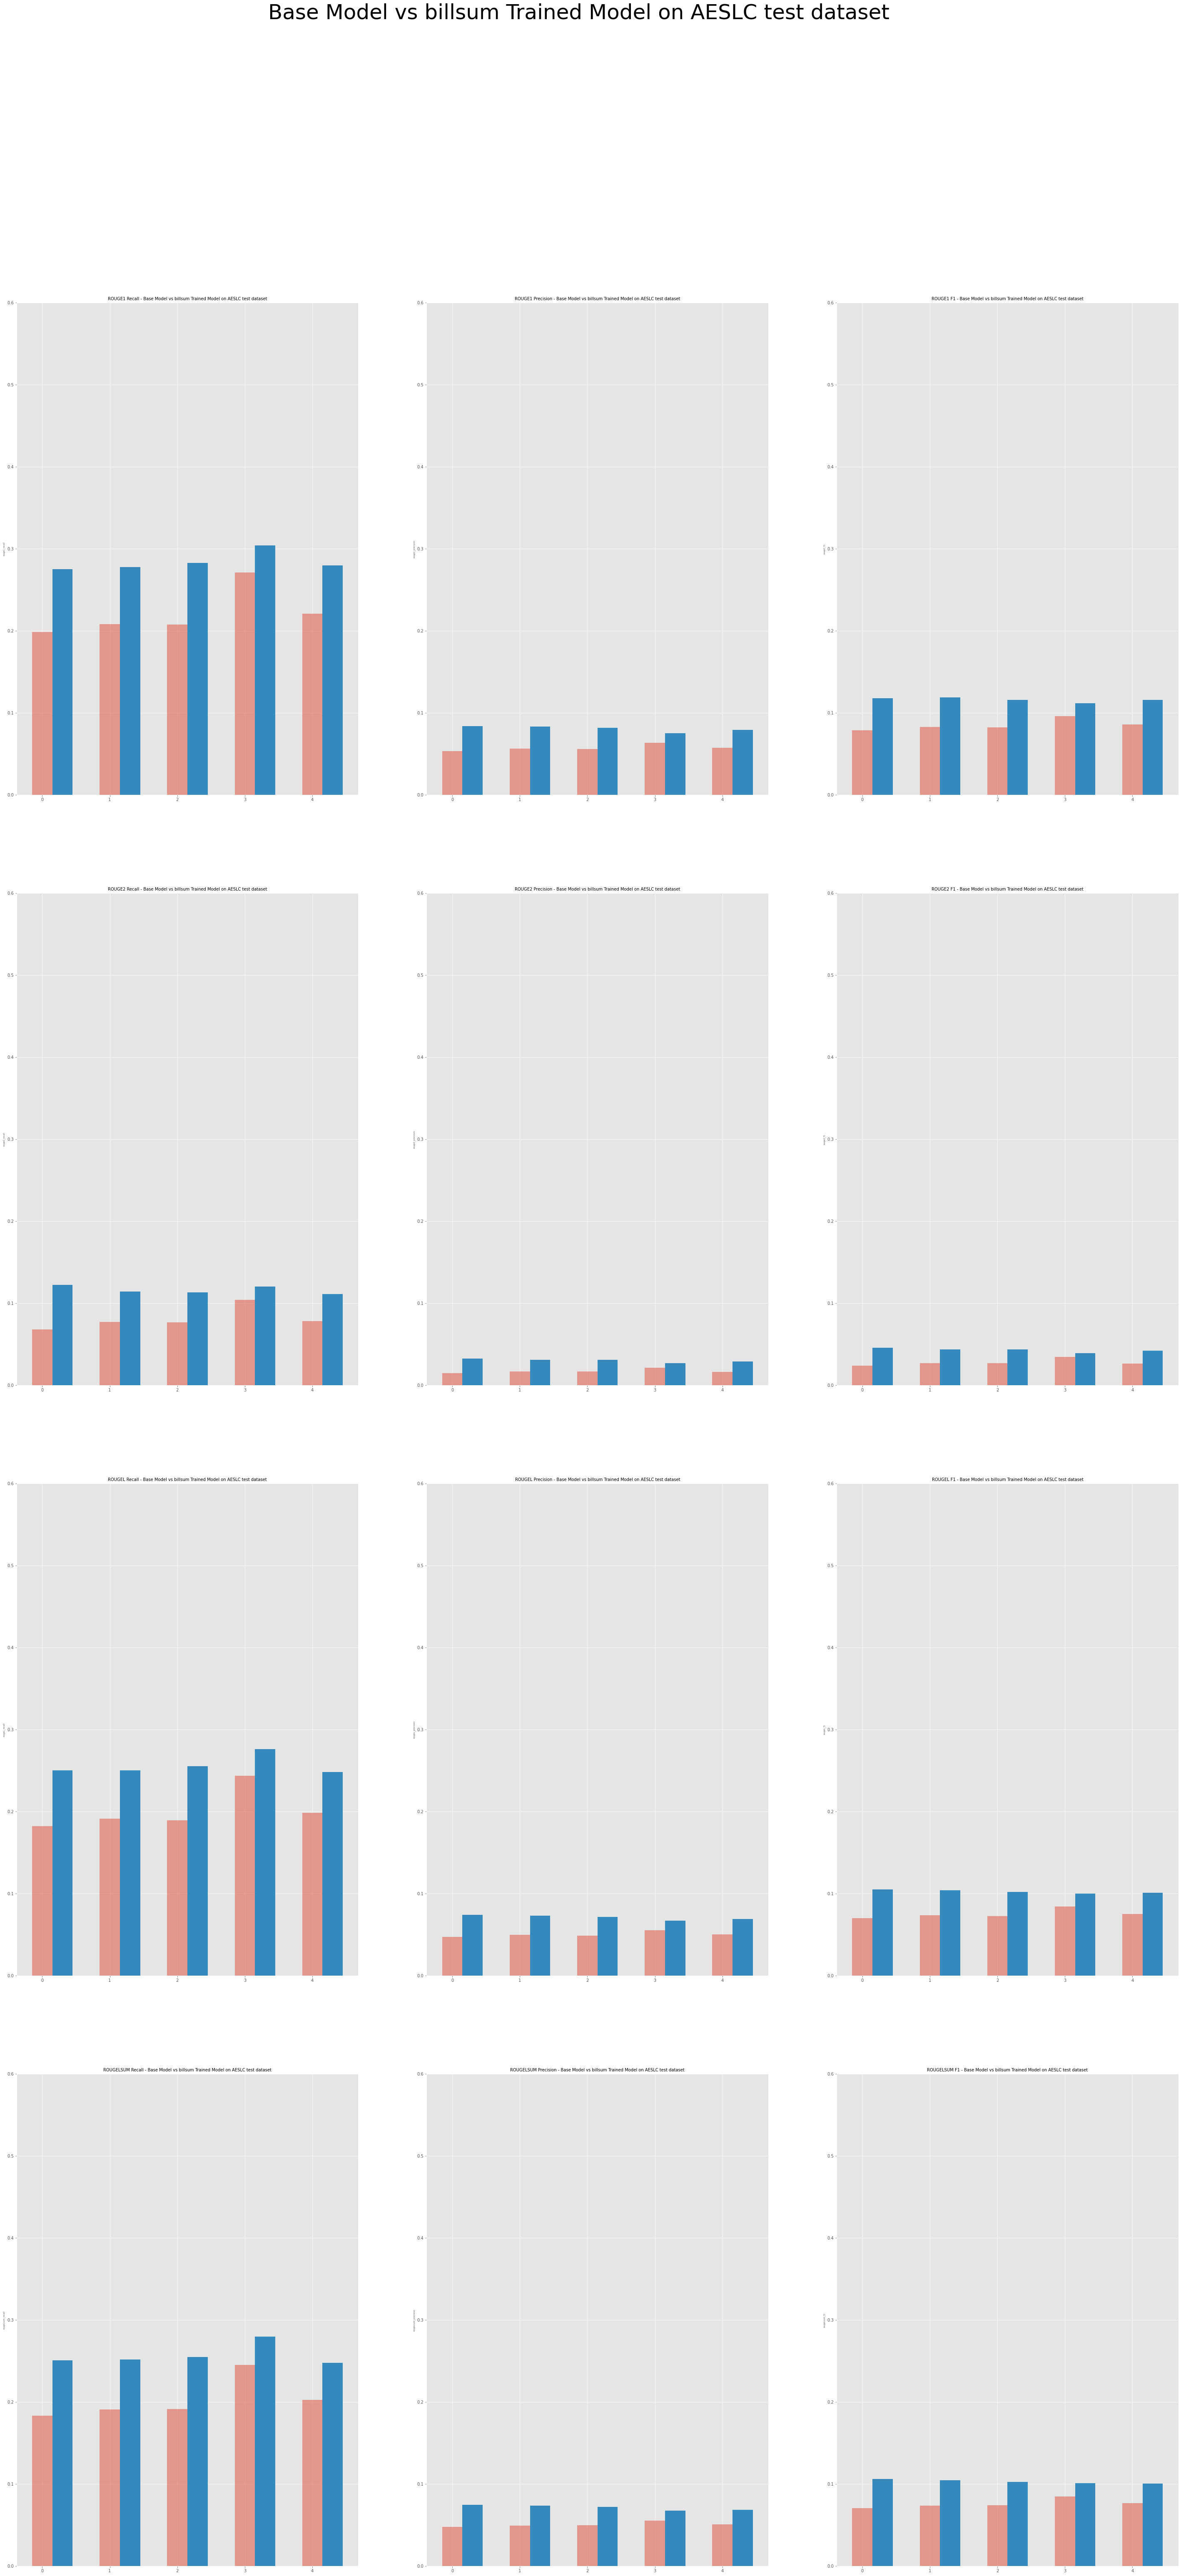

In [ ]:
import pandas as pd

# base Model evaluating cnn dataset

base_aeslc_file_name = "text_metrics-1500000-.test.txt"
base_aeslc_dirs = ['base_aeslc_bs10_ba1', 'base_aeslc_bs10_ba5', 'base_aeslc_bs10_ba9', 'base_aeslc_bs1_ba5', 'base_aeslc_bs5_ba5']
base_aeslc_stats = collectStats(base_aeslc_file_name, base_aeslc_dirs)
print(base_aeslc_stats)

# billsum Model evaluating cnn dataset
billsum_aeslc_file_name = "text_metrics-180000-.test.txt"
billsum_aeslc_dirs = ['billsum_aeslc_bs10_ba1', 'billsum_aeslc_bs10_ba5', 'billsum_aeslc_bs10_ba9', 'billsum_aeslc_bs1_ba5', 'billsum_aeslc_bs5_ba5']
billsum_aeslc_stats = collectStats(billsum_aeslc_file_name, billsum_aeslc_dirs)
print(billsum_aeslc_stats)

print("\n\nBar Pairs in each subplot represent each experiment varying beam size and beam alpha\n\n\n" )
exp = ['Beam Size 10 and beam alpha 0.1', 'Beam Size 10 and beam alpha 0.5', 
       'Beam Size 10 and beam alpha 0.9', 'Beam Size 1 and beam alpha 0.5', 
       'Beam Size 1 and beam alpha 0.5'] 
print(pd.DataFrame(exp, columns =['Experiments']))    
print("\n\n\n\n")


draw_plots('Base Model vs billsum Trained Model on AESLC test dataset',
           base_aeslc_stats, "Base_Model", billsum_aeslc_stats,
           "billsum_Model", "base_vs_billsum_on_aeslc.png")



{'rouge1': {'R': {'min': [0.150371, 0.194432, 0.230267, 0.23141599999999998, 0.208207], 'max': [0.196347, 0.24493800000000002, 0.278918, 0.277136, 0.25542], 'avg': [0.17219, 0.218935, 0.25438099999999997, 0.254882, 0.23054499999999997]}, 'P': {'min': [0.403484, 0.292605, 0.212376, 0.186792, 0.273556], 'max': [0.48114300000000004, 0.36624, 0.27068600000000004, 0.23960700000000001, 0.35440900000000003], 'avg': [0.44276000000000004, 0.330098, 0.24027199999999999, 0.21235500000000002, 0.314652]}, 'F': {'min': [0.200232, 0.201647, 0.200249, 0.189054, 0.204546], 'max': [0.246121, 0.24303200000000003, 0.241666, 0.232026, 0.24612199999999998], 'avg': [0.221898, 0.22184099999999998, 0.22094699999999998, 0.21057199999999998, 0.225282]}}, 'rouge2': {'R': {'min': [0.047727, 0.051346, 0.058275, 0.049602, 0.051167000000000004], 'max': [0.074379, 0.07914199999999999, 0.085487, 0.069373, 0.07750900000000001], 'avg': [0.060004999999999996, 0.064928, 0.070772, 0.059739999999999994, 0.063372]}, 'P': {'mi

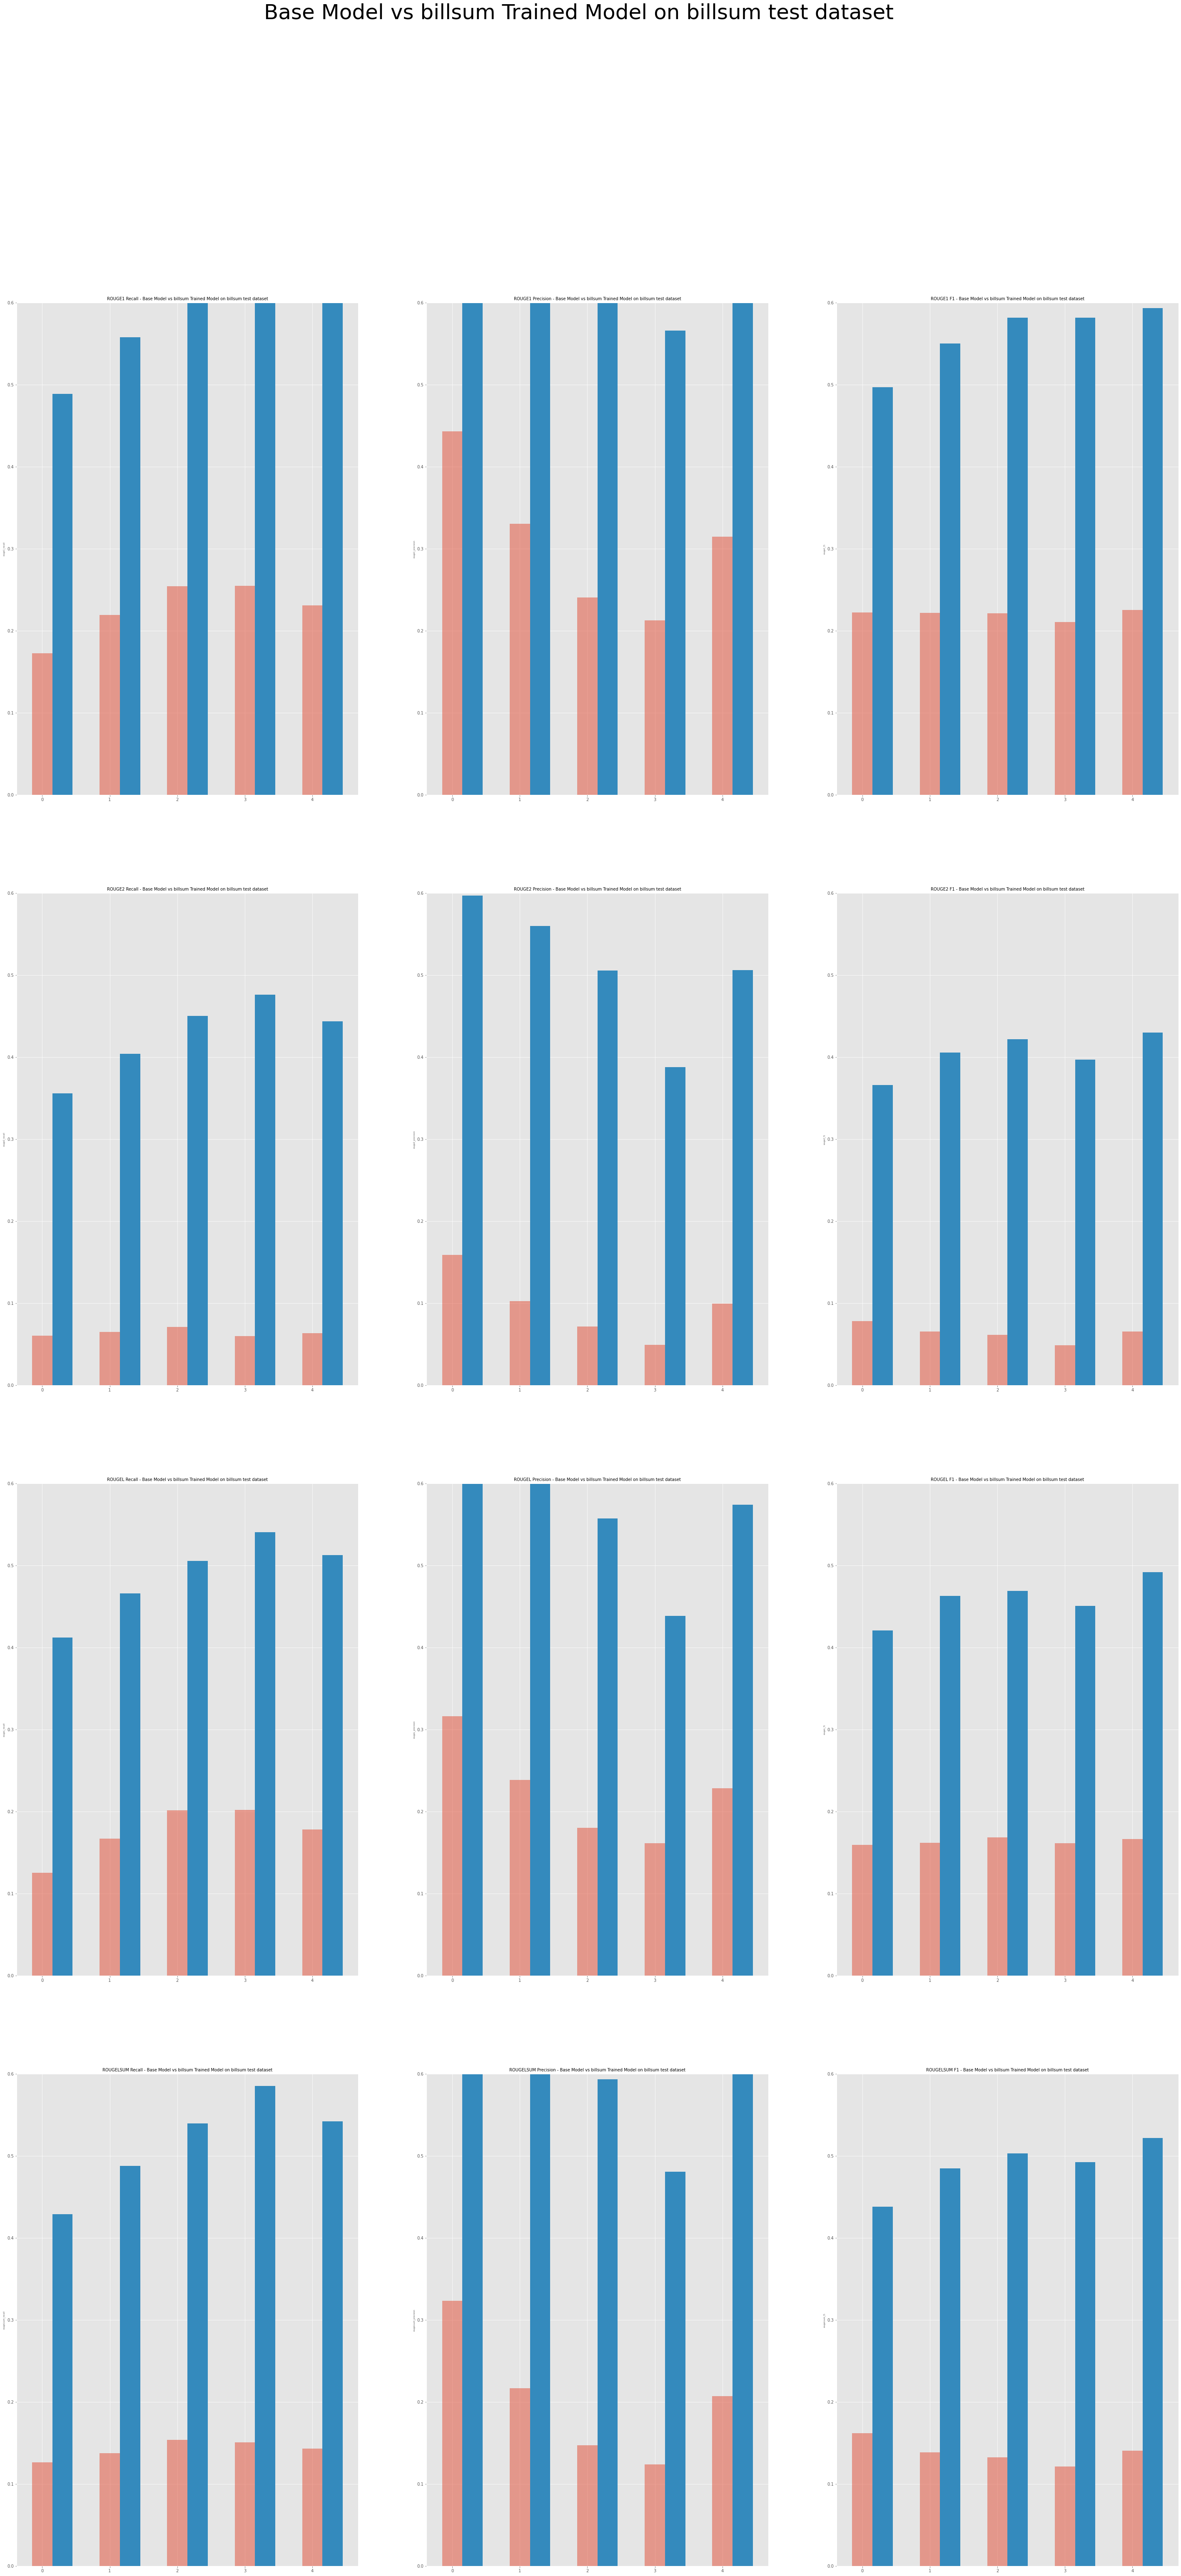

In [ ]:
import pandas as pd

# base Model evaluating cnn dataset

base_billsum_file_name = "text_metrics-1500000-.test.txt"
base_billsum_dirs = ['base_billsum_bs10_ba1', 'base_billsum_bs10_ba5', 'base_billsum_bs10_ba9', 'base_billsum_bs1_ba5', 'base_billsum_bs5_ba5']
base_billsum_stats = collectStats(base_billsum_file_name, base_billsum_dirs)
print(base_billsum_stats)

# billsum Model evaluating cnn dataset
billsum_billsum_file_name = "text_metrics-180000-.test.txt"
billsum_billsum_dirs = ['billsum_bs10_ba1', 'billsum_bs10_ba5', 'billsum_bs10_ba9', 'billsum_bs1_ba5', 'billsum_bs5_ba5']
billsum_billsum_stats = collectStats(billsum_billsum_file_name, billsum_billsum_dirs)
print(billsum_billsum_stats)

print("\n\nBar Pairs in each subplot represent each experiment varying beam size and beam alpha\n\n\n" )
exp = ['Beam Size 10 and beam alpha 0.1', 'Beam Size 10 and beam alpha 0.5', 
       'Beam Size 10 and beam alpha 0.9', 'Beam Size 1 and beam alpha 0.5', 
       'Beam Size 1 and beam alpha 0.5'] 
print(pd.DataFrame(exp, columns =['Experiments']))    
print("\n\n\n\n")


draw_plots('Base Model vs billsum Trained Model on billsum test dataset',
           base_billsum_stats, "Base_Model", billsum_billsum_stats,
           "billsum_Model", "base_vs_billsum_on_billsum.png")

